<a href="https://colab.research.google.com/github/Kevin2558/Data_Science_Borrador/blob/main/10_Proyecto_Final/Opcion_2/Borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación de objetos estelares (estrellas, galaxias y cuásares)**

El proyecto se enfoca principalmente en construir un modelo de clasificación de objetos estelares, esto en ayuda de aficionados por la astronomía con y sin experiencia que deseen identificar, a través de magnitudes físicas y/o imágenes, lo que observan en el cielo exterior.

Separaremos el proyecto en dos aristas. Primero analizaremos las magnitudes fotométricas de los objetos en distintos rangos de longitud de onda y luego analizaremos imágenes de estrellas y galaxias. Estos dos enfoques buscan comprender un gran número de personas, en distinto niveles de conocimiento en astronomía.

# **Parte 1**

El primer objetivo es construir un modelo que clasifique los objetos estelares a través de las magnitudes fotométricas de los objetos estelares. Para esto usaremos modelos de machine learning de clasificación supervisada. Se detallará el proceso completo hasta la obtención del modelo más adecuado para responder a esta problemática.

# **Librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
!pip install xgboost
from xgboost import XGBClassifier

# **Dataset**

El dataset a utilizar en la primera parte de este proyecto consiste en una colección de 10.000 observaciones del espacio tomadas por la Sloan Digital Sky Survey. Cada observación está descrita por 17 características y una variable objetivo la cual identifica la observación como una estrella, una galaxia o un quásar.

Las distintas características son las siguientes:

1. **objid:** Identador único para cada objeto estelar.
2. **ra:** Ascensión Recta (RA), coordenada de longitud en el cielo.
3. **dec:** Declinación (Dec), coordenada de latitud en el cielo.
4. **u, g, r, i y z:** Magnitudes fotométricas en cinco bandas del sistema SDSS (utravioleta, verde, rojo, infrarrojo cercano e infrarrojo). Estas representan el brillo del objeto en distintos rangos de longitud de onda.
5. **run:** Número de ejecución (scan run) durante la captación de la imagen.
6. **rerun:** Número de re-ejecución del procesamiento de la imagen.
7. **camcol:** Columna de cámara; indica la fila del CCD utilizada en el escaneo.
8. **field:** Identificador del campo (región del cielo) en el escaneo.
9. **specobjid:** ID único del objeto en el catálogo espectroscópico.
10. **redshift:** Corrimiento al rojo (z), indicador de distancia y velocidad del objeto respecto a la Tierra.
11. **plate:** ID de placa espectroscópica usada en la observación.
12. **mjd:** Modified Julian Date, fecha de observación en formato científico Julina.
13. **fiberid:** ID de fibre óptica que capturó la luz del objeto para espectroscopía.
14. **class:** Variable objetivo que indica la clase astronómica del objeto (galaxia, estrella o quásar).

Notemos que hay varias características que no aportan información relevante al momento de realizar el análisis de los datos para una próxima clasificación, por lo que se procederá a separar las variables con mayor importancia para la realización del proyecto.

Lo anterior refleja la importancia de entender el contexto de las variables, para que estas no generen ruido innecesario al momento del modelamiento o produzcan predicciones erróneas.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Kevin2558/Data_Science_Borrador/main/10_Proyecto_Final/Opcion_2/SDSS_Data.csv")
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


# **Análisis Exploratorio de Datos (EDA)**

Como análizamos al comienzo, eliminaremos del dataset las variables que no aportan en este análisis y nos centraremos en las que si aportan información valiosa.

In [ ]:
df = df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'plate', 'mjd', 'fiberid'], axis=1)
df.head()

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


Partiremos realizando una visualización espacial de los objetos estelares a través de las variables ra y dec, las cuales representan las coordenadas en el cielo de estas.

Esto para tener un primer vistazo del dataset, comprender si existen cúmulos de galaxias o sectores con alta densidad de estrellas y analizar visualmente la frecuencia de cada objeto y determinar la necesidad de un balanceo de clases.

En el caso de que espacialmente representen agrupaciones las utilizaremos para el modelamiento y predicción. En el caso de que las agrupaciones estén en su mayoría acopladas, la usaremos únicamente como una primera visualización de los datos.

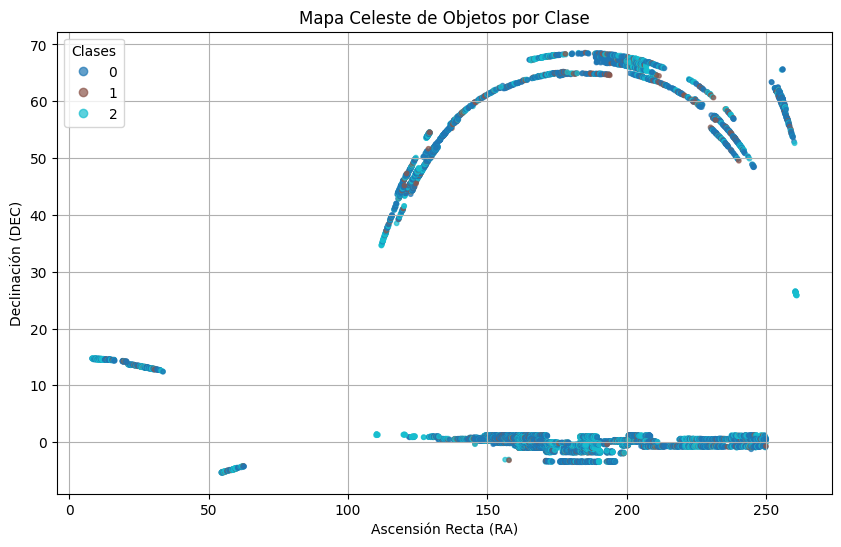

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['ra'], df['dec'], c=df['class'].astype('category').cat.codes, cmap='tab10', alpha=0.7, s=10)
plt.legend(*scatter.legend_elements(),title="Clases")
plt.xlabel('Ascensión Recta (RA)')
plt.ylabel('Declinación (DEC)')
plt.title('Mapa Celeste de Objetos por Clase')
plt.grid(True)
plt.show()

Como podemos notar, los elementos de la clase 0 (galaxias) son los que se ven más representados, luego le siguen los de la clase 2 (estrellas) y por último los objetos de la clase 1 (cuásares) se ven muy poco representados.

Esto evidencia una necesidad de balanceo de clases para que los modelos aprendan significativamente como identificar cada clase y no predomine la que posee más casos.

Como dijimos antes, los datos espacialmente no representan notoriamente agrupaciones, por lo que procederemos a eliminarlas.

Así, el proyecto de clasificación se centrará en analizar los objetos estelares a través de las variables u, g, r, i, z y redshift.

In [ ]:
df = df.drop(['ra', 'dec'], axis=1)
df.head()

,u,g,r,i,z,class,redshift
0,19.47406,17.04240,15.94699,15.50342,15.22531,STAR,-0.000009
1,18.66280,17.21449,16.67637,16.48922,16.39150,STAR,-0.000055
2,19.38298,18.19169,17.47428,17.08732,16.80125,GALAXY,0.123111
3,17.76536,16.60272,16.16116,15.98233,15.90438,STAR,-0.000111
4,17.55025,16.26342,16.43869,16.55492,16.61326,STAR,0.000590


Veamos si el dataset presenta valores nulos. De llegar a tenerlos se procederá a analizar la acción sobre ellos.

In [ ]:
df.isnull().sum()

,0
u,0
g,0
r,0
i,0
z,0
class,0
redshift,0


Visualicemos las estadísticas descriptivas básicas del dataset para evaluar, a primera vista, que columnas pueden poseer outliers.

In [ ]:
df.describe()

,u,g,r,i,z,redshift
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.619355,17.371931,16.840963,16.583579,16.422833,0.143726
std,0.828656,0.945457,1.067764,1.141805,1.203188,0.388774
min,12.988970,12.799550,12.431600,11.947210,11.610410,-0.004136
25%,18.178035,16.815100,16.173333,15.853705,15.618285,0.000081
50%,18.853095,17.495135,16.858770,16.554985,16.389945,0.042591
75%,19.259232,18.010145,17.512675,17.258550,17.141447,0.092579
max,19.599900,19.918970,24.802040,28.179630,22.833060,5.353854


Notemos que hay variables donde los mínimos y/o máximos se alejan considerablemente de la media por lo que esto se consideraría una primera observación a la posibilidad de existencia de outliers.

Además, notemos que todas las variables de magnitudes fotométricas poseen varianzas y medias similares.



Transformemos la variable objetivo 'class' a variable categórica para poder utilizarla en los modelos.

In [ ]:
df['class'] = df['class'].astype('category').cat.codes
df['class'].head()

,class
0,2
1,2
2,0
3,2
4,2


Separemos los datos entre características y variables objetivo.


In [ ]:
X = df.drop('class', axis=1)
y = df['class']

Realicemos histogramas por variables para ver cómo se distribuye el dataset.

Además lo separaremos por clases para ver si el comportamiento de cada variable se mantiene en las clases o hay clases que presentan comportamientos diferentes.

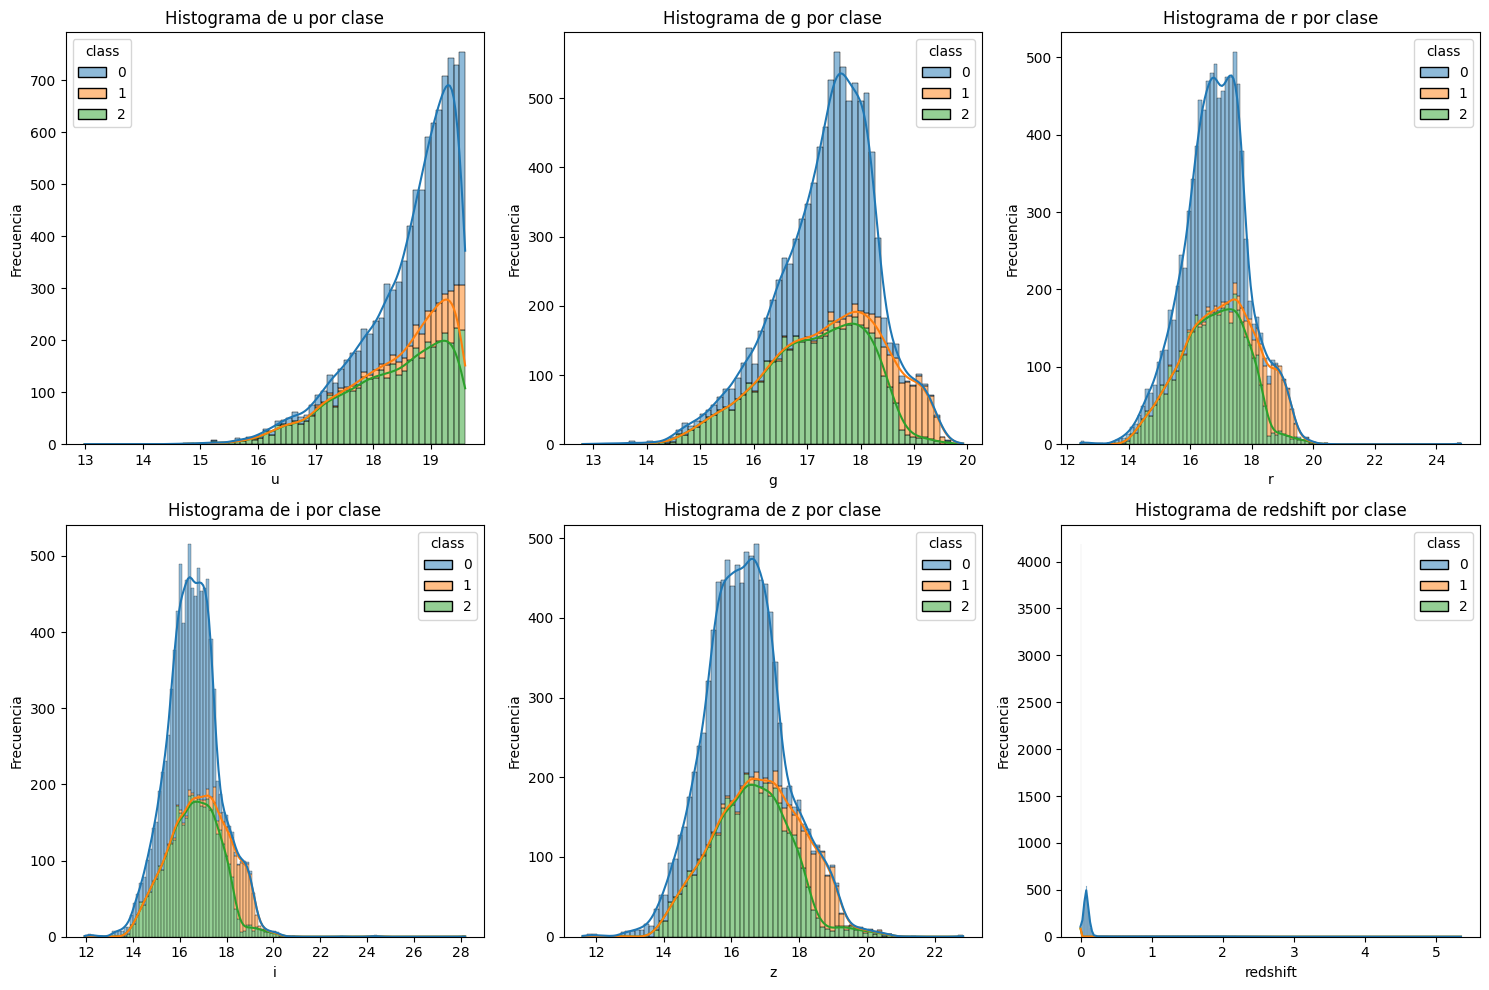

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.histplot(data=df, x=feature, hue='class', multiple='stack', kde=True, palette='tab10',ax=axes[i])
    axes[i].set_title(f'Histograma de {feature} por clase')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

Como podemos notar las 5 magnitudes fotométricas se comportan como una variable normal y este comportamiento se mantiene en todas las clases.

También se puede evidenciar el desbalance de clases, por lo que más adelante lo trataermos.

Ahora, visualicemos el comportamiento de los datos outliers por magnitud fotométrica y la cantidad total de ellos.

Observemos gráficos boxplots por clases comprobar la primera idea que tuvimos respecto a los datos outliers.

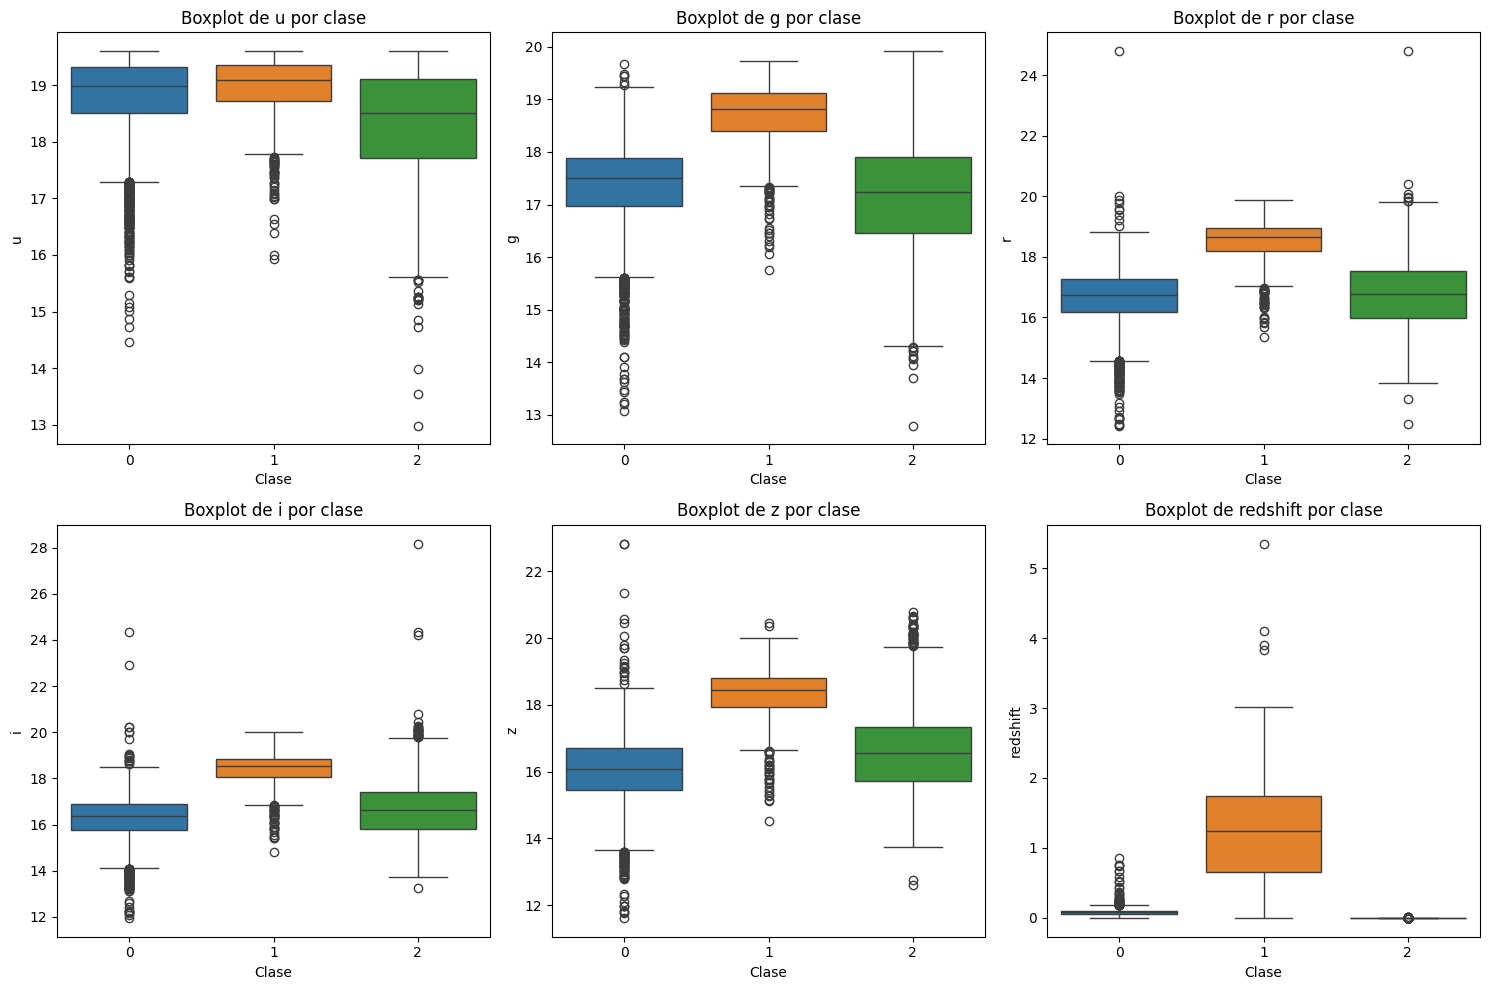

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(X.columns):
    sns.boxplot(x='class', y=feature, data=df, hue='class', palette='tab10', legend=False, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature} por clase')
    axes[i].set_xlabel('Clase')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

Como se puede observar, se evidencia una cantidad notable de outliers en todas las variables y en todas las clases.

Hay casos (como la clase 2 en la variable fotométrica r) donde le número de outliers es despreciable, pero como el fenómeno se mantiene en general se considerará el tratamiento de ellos.

Calculemos el número de outliers según IQR y según z-score.

In [ ]:
from scipy import stats

outliers = 0
for feature in X.columns:
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers_iqr = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
  outliers += len(outliers_iqr)

print(f'Número de outliers según IQR: {outliers}')
print(f'Porcentaje de outlier según IQR: {outliers/10000*100:.1f}%')

print('')
z_scores = np.abs(stats.zscore(X))

outliers = (z_scores > 3).any(axis=1)
print(f"Número de outliers según z-score: {outliers.sum()}")
print(f'Porcentaje de outlier según z-score: {outliers.sum()/10000*100:.1f}%')

Número de outliers según IQR: 1575
Porcentaje de outlier según IQR: 15.8%

Número de outliers según z-score: 532
Porcentaje de outlier según z-score: 5.3%


Y como se evidenció anteriormente, hay una gran presencia de datos outliers, por lo que se tendrá en cuenta cuando se comience el tratamiento de los datos para el modelado.

Visualicemos la matriz de correlación para ver cuales son las variables que están altamente correlacionadas.

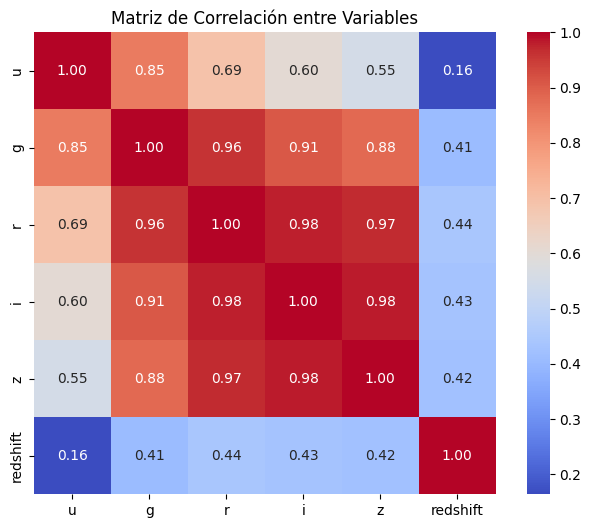

In [ ]:
plt.figure(figsize=(8, 6))
corr = X.corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Matriz de Correlación entre Variables')
plt.show()

Como podemos notar, las variables de magnitudes fotométricas presentan alta correlación entre todas (0.88 - 0.98) lo cual es esperable debido a que estas miden el nivel de brillo de los objetos en bandas de longitud de onda cercanas. La única que no representa correlaciones tan altas es u con todas las demás, aunque con g es relativamente alta.

Como observación, se puede notar que redshift tiene una correlación moderada con las variables, lo cual argumenta nuestra primer decisión de mantenerla para el análisis ya que esta variable entregará información adicional y de valor al momento de la toma de decisiones dentro del entrenamiento y de las predicciones.

Construyamos gráficos de dispersión entre las variables para observar estas correlaciones.

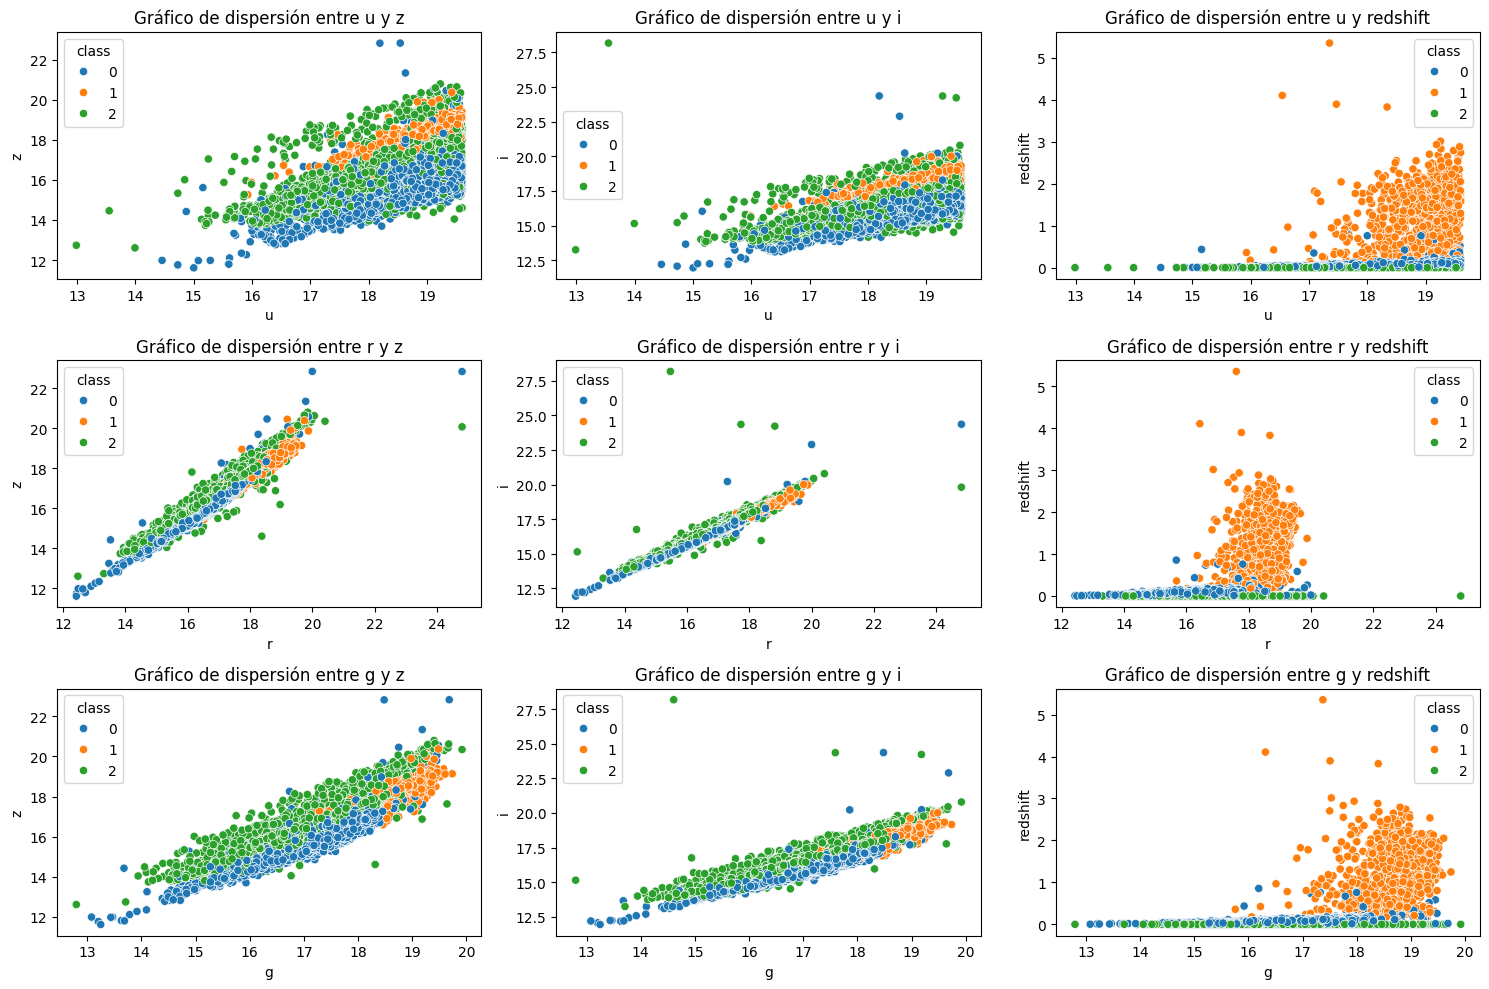

In [ ]:
ejex = ['u','r','g']
ejey = ['z','i','redshift']

fig, axes = plt.subplots(
    len(ejex),
    len(ejey),
    figsize=(15, 10)
)

axes = axes.flatten()

for i, feature_x in enumerate(ejex):
    for j, feature_y in enumerate(ejey):
        sns.scatterplot(
            x=feature_x,
            y=feature_y,
            data=df,
            hue='class',
            palette='tab10',
            ax=axes[i * len(ejey) + j]
        )
        axes[i * len(ejey) + j].set_title(f'Gráfico de dispersión entre {feature_x} y {feature_y}')
        axes[i * len(ejey) + j].set_xlabel(feature_x)
        axes[i * len(ejey) + j].set_ylabel(feature_y)

plt.tight_layout()
plt.show()

A través de los gráficos de dispersión se puede observar que nuevamente se evidencia una alta correlación entre las magnitudes fotométricas, al igual que lo visto en la matriz de correlación. Pero entre las magnitudes fotométricas y redshift se nota una correlación casi nula en las clases 0 y 2. Además, la clase 1 provoca un valor de 0.4 en las correlaciones vistas en la matriz.

Veamos si el dataset presenta filas duplicadas para la eliminación de ellas (evitar redundancia).

In [ ]:
duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates}")

Número de filas duplicadas: 0


# **Visualización**

Realizaremos una reducción de dimensionalidad para la visualización 2D de los datos a través de t-SNE.

Se escoge realizar la visualización a través de t-SNE debido a que las variables fotométricas presentan relaciones complejas y posiblemente no lineales. Esto nos ayudará a explorar la estructura de los datos y visualizar posibles agrupaciones o transiciones suaves entre clases.

Escalaremos con RobustScaler debido a que en el cálculo de outliers, eran 1.000 de 10.000 datos, lo que pueden influir en nuestro análisis.

In [ ]:
X_scaled = RobustScaler().fit_transform(X)

tsne = TSNE(n_components=2,
            perplexity=48,
            learning_rate=200,
            random_state=42)

X_tsne = tsne.fit_transform(X_scaled)

Visualización.

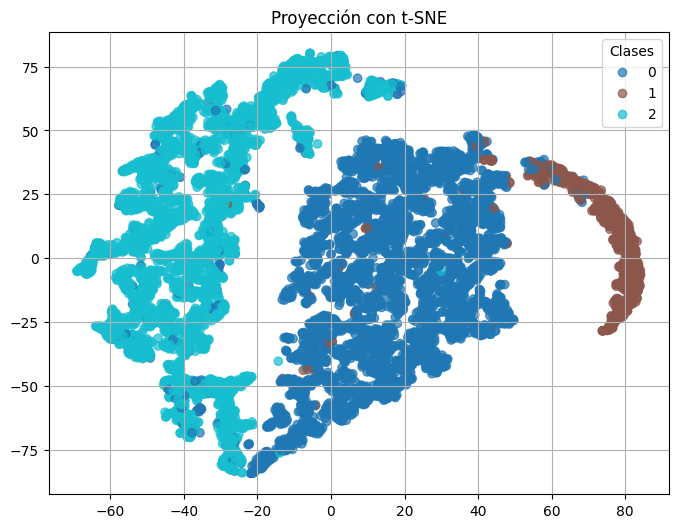

In [ ]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(),title="Clases")
plt.title("Proyección con t-SNE")
plt.grid(True)
plt.show()

Como podemos observar las clases tienen un claro comportamiento separable. Esto representará ventajas a la hora de la elección de modelos ya que esto es fundamental para el buen funcionamiento de alguno de ellos.

# **Balanceo de clases**

Primero, realicemos la división de los datos entre entrenamiento y testeo en una proporción 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

Ahora, comencemos con el tratamiento del evidente desbalanceo de clases.

Realicemos un gráfico de frecuencias por clases.

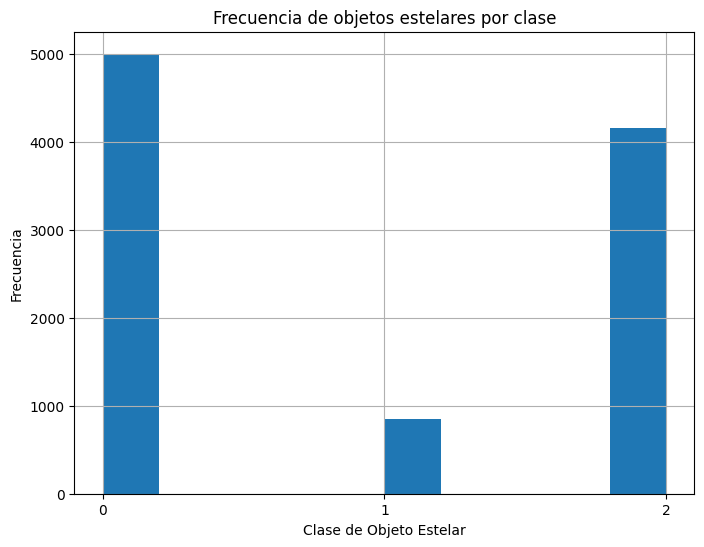

In [ ]:
plt.figure(figsize=(8, 6))
y.hist()
plt.xticks(sorted(y_train.unique()), y_train.astype('category').cat.categories)
plt.title('Frecuencia de objetos estelares por clase')
plt.xlabel('Clase de Objeto Estelar')
plt.ylabel('Frecuencia')
plt.show()

Esto termina de evidenciar el notable desbalanceo de clases, por lo que se procederá a balancearlas.

Clases balanceadas a través de SMOTE.

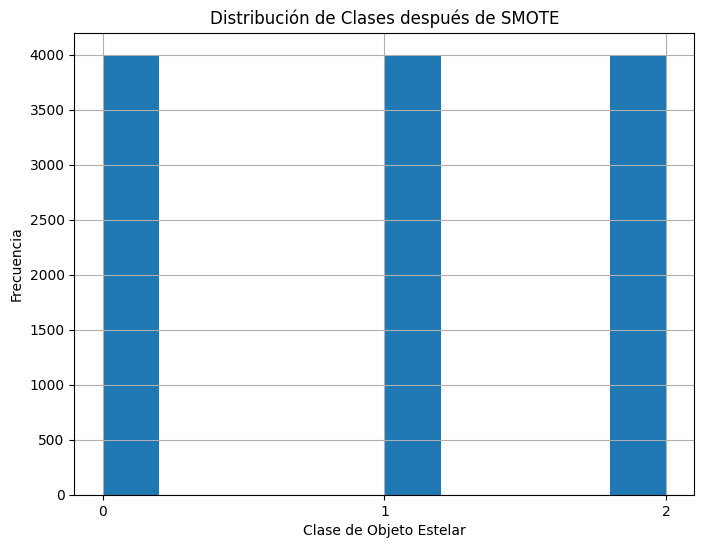

In [ ]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_train, y_train)

plt.figure(figsize=(8, 6))
y_bal.hist()
plt.xticks(sorted(y_bal.unique()), y_bal.astype('category').cat.categories)
plt.title('Distribución de Clases después de SMOTE')
plt.xlabel('Clase de Objeto Estelar')
plt.ylabel('Frecuencia')
plt.show()

Realizado el balanceo de clases pertinente, procedamos al modelamiento y predicción.

# **Modelamiento**

Tomando el cuenta el EDA realizado anteriormente, los modelos a utilizar son:

* K-NN
* SVC (kernel RBF)
* Random Forest
* XGBoost
* MLP (una capa de 100 neuronas)
* MLP (tres capas de 100, 50 y 25 neuronas)

Las justificaciones de utilización de cada uno de estos modelos se explicitarán en cada apartado.

## K-NN

Lo utilizaremos como modelo simple, por rapidez y por ser no paramétrico. Notemos que como las clases están bien separadas k-NN predecirá de buena forma.

In [ ]:
knn = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=3,
                                 p=2,
                                 metric='minkowski'
    ))
])

Entrenamiento.

In [ ]:
knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

## SVC (kernel RBF)

Lo utilizaremos debido a que como vimos en la visualización con t-SNE están notablemente separadas, por lo que este modelo podria funcionar bien. Utilizaremos kernel RBF debido al carácter no lineal de la distribución de los datos.

In [ ]:
svc = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(random_state=42,
                C=0.1,
                kernel='rbf',
                gamma='scale'
    ))
])

Entrenamiento.

In [ ]:
svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('svc', SVC(C=0.1, random_state=42))])

## Random Forest

Lo utilizaremos como primer modelo bien robusto, el cual nos puede dar buenas predicciones, además de su buena interpretabilidad al momento de mostrar el árbol generado.


In [ ]:
rf = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42,
                                  n_estimators=100,
                                  max_depth=None
                                  ))
])

Entrenamiento.

In [ ]:
rf.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

## XGBoost

Lo utilizaremos debido a su posible mejoría con respecto a Random Forest, además de ser un modelo generalmente utilizado por su buen rendimiento. También representa un modelo bien interpretable debido a la disponibilidad de mostrar el árbol generado.

In [ ]:
xgb = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100,
                          learning_rate=1.0,
                          max_depth=3,
                          random_state=42
                          ))
])

Entrenamiento.

In [ ]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

## MLP

Lo utilizaremos por ser una opción muy viable debido a su potencia en clasificación no lineal. Utilizaremos 2 redes, una más simple que la otra.

In [ ]:
mlp_100 = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100,),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          ))
])

mlp_1005025 = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100, 50, 25),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          ))
])

Entrenamiento.

In [ ]:
mlp_100.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('mlp', MLPClassifier(max_iter=1000, random_state=42))])

In [ ]:
mlp_1005025.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('mlp',
                 MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000,
                               random_state=42))])

# **Fronteras de decisión**

Algunos de los modelos presentan posibles visualizaciones que nos ayudan a comprender cómo se desarrolla la toma de decisiones al momento de predecir. Mostraremos las fronteras de decisión y los árboles correspondientes.

Usaremos la reducción de dimensionalidad, realizada anteriormente, utilizando t-SNE para visualizar.

## **k-NN**

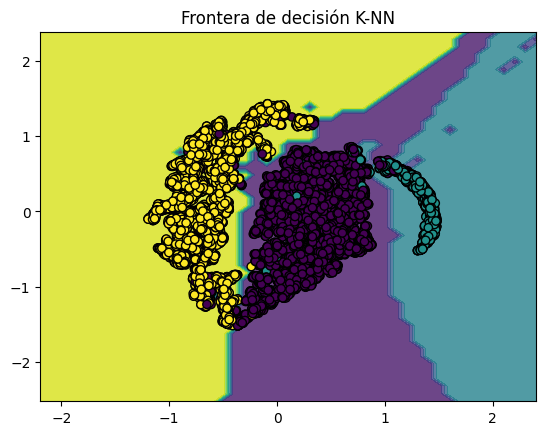

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

knn_vis = KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski')
knn_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión K-NN")
plt.show()

## **SVC (kernel RBF)**

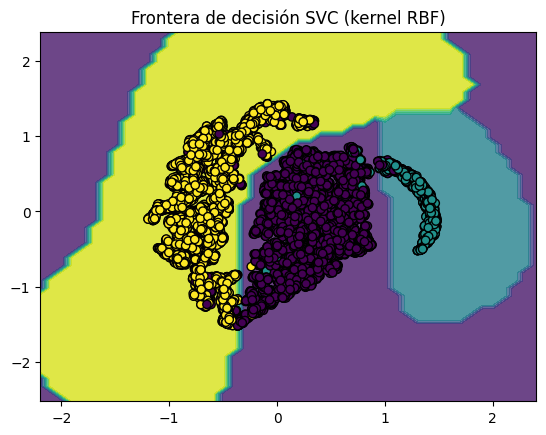

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

svc_vis = SVC(random_state=42, C=0.1, kernel='rbf', gamma='scale')
svc_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = svc_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión SVC (kernel RBF)")
plt.show()

## **Random Forest**

En este caso podemos visualizar el árbol generado por el Random Forest.

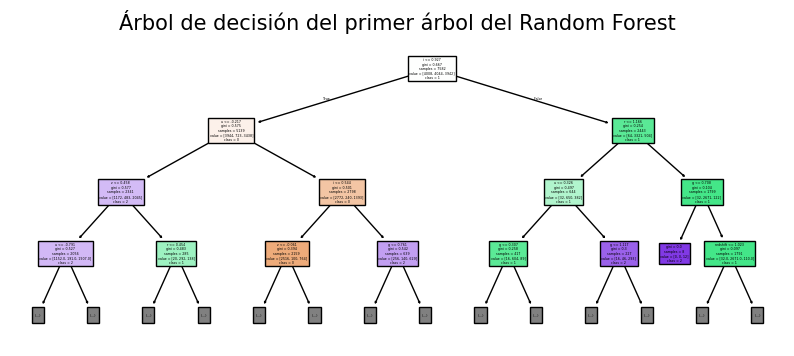

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

rf_model = rf.named_steps["rf"]
first_tree = rf_model.estimators_[0]
model_classes = rf_model.classes_
class_names_list = [str(cls) for cls in model_classes]

plt.figure(figsize=(10, 4))
plot_tree(first_tree, filled=True, feature_names=X_train.columns, class_names=class_names_list, max_depth=3)
plt.title("Árbol de decisión del primer árbol del Random Forest",fontsize=15)
plt.show()

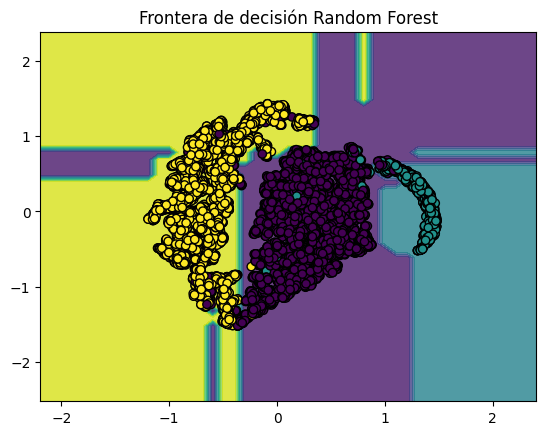

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

rf_vis = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None)
rf_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = rf_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión Random Forest")
plt.show()

## **XGBoost**

Al igual que con Random Forest podemos visualizar el árbol de decisión.

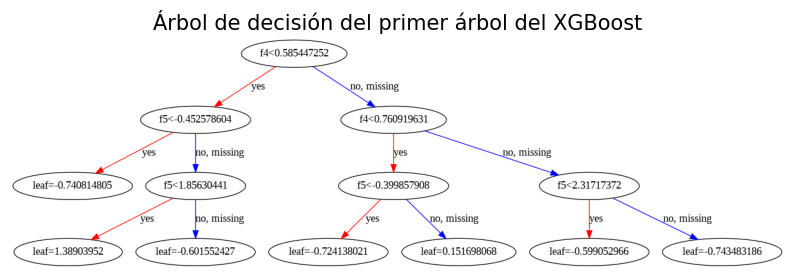

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

xgb_model = xgb.named_steps['xgb']
booster = xgb_model.get_booster()

plt.figure(figsize=(10,4))
plot_tree(booster,num_trees=0,filled=True, ax=plt.gca())
plt.title("Árbol de decisión del primer árbol del XGBoost",fontsize=15)
plt.show()

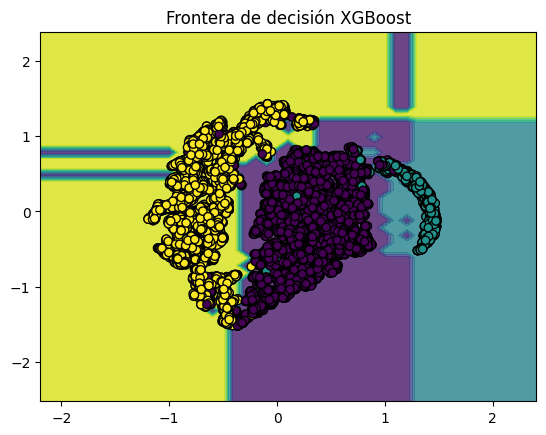

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

xgb_vis = XGBClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)
xgb_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = xgb_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión XGBoost")
plt.show()

## **MLP**

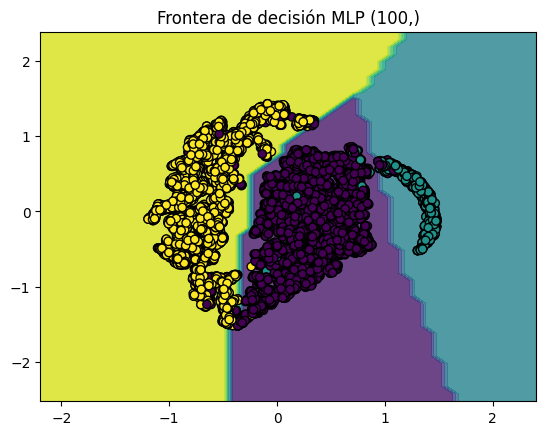

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

mlp100_vis = MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100,),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          )
mlp100_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = mlp100_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión MLP (100,)")
plt.show()

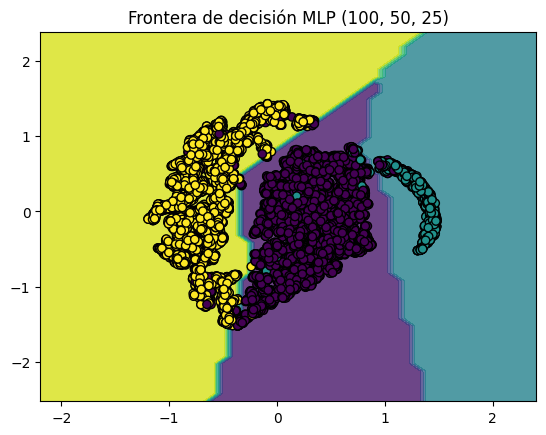

In [ ]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_tsne)

mlp1005025_vis = MLPClassifier(random_state=42,
                          max_iter=1000,
                          hidden_layer_sizes=(100,50,25),
                          activation='relu',
                          solver='adam',
                          learning_rate='constant'
                          )
mlp1005025_vis.fit(X_scaled, y)

x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = mlp1005025_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Frontera de decisión MLP (100, 50, 25)")
plt.show()

## **Observaciones**

Podemos notar que las fronteras de decisión poseen formas diferentes dependiendo del modelo utilizado.

* El modelo k-NN posee fronteras más lineales e irregulares.

* El modelo SVC debido a usar kernel RBF posee fronteras mucho más suaves y se acercan a ser curvas. Separa de buena forma las clases.

* El modelo RF y XGB posee fronteras complejas y bien lineales. Esta complejidad se evidencia en las zonas donde las clases se intersectan.

* Los modelos MLP poseen fronteras que tienden a ser suaves. El primer modelo es mucho más lineal que el segundo, el cual intenta cubrir la complejidad de la intersección entre clases.

A primera vista todos los modelos tienden a comprender de buena forma las tres distintas clases, por lo  que se espera tener buenas predicciones.

# **Predicción y Evaluación**

Por último, realicemos la predicción de los modelos y visualicemos las métricas que evalúan su predicción.

## Reportes de métricas para clasificación.

In [ ]:
y_pred = []
model_names = ["K-NN", "SVC (kernel RBF)", "Random Forest", "XGBoost", "MLP (100)", "MLP (100, 50, 25)"]
models = [knn, svc, rf, xgb, mlp_100, mlp_1005025]

for i, model in enumerate(models):
  y_pred.append(model.predict(X_test))
  print("Reporte del modelo", model_names[i])
  print('')
  print(classification_report(y_test, y_pred[-1]))
  print("-" * 50)

Reporte del modelo K-NN

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.96      0.96      0.96       170
           2       0.97      1.00      0.99       830

    accuracy                           0.98      2000
   macro avg       0.97      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

--------------------------------------------------
Reporte del modelo SVC (kernel RBF)

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1000
           1       0.98      0.94      0.96       170
           2       0.88      1.00      0.94       830

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

--------------------------------------------------
Reporte del modelo Random Forest

              precision    recall  f1-sc

**Tabla Comparativa de Métricas Clave de Modelos**

La siguiente tabla se centra en las métricas más relevantes para comparar el rendimiento general de los modelos y su capacidad para manejar el desbalance de clases: Accuracy, Macro Average F1-score (promedio simple de F1-scores por clase) y F1-score para la Clase 1 (la clase minoritaria).

| Modelo            | Accuracy | Macro Avg F1-score | Class 1 F1-score | Execution Time (s) |
|-------------------|----------|--------------------|------------------|--------------------|
| K-NN              | 0.98     | 0.98               | 0.96             | 0 seg                 |
| SVC (kernel RBF)  | 0.94     | 0.94               | 0.96             | 2 seg                 |
| Random Forest     | 0.99     | 0.98               | 0.96             | 3 seg                 |
| XGBoost           | 0.99     | 0.98               | 0.96             | 0 seg                 |
| MLP (100)         | 0.99     | 0.98               | 0.96             | 16 seg                |
| MLP (100, 50, 25) | 0.99     | 0.98               | 0.97             | 20 seg                |

Notemos que todos los modelos se desempeñan de buena forma y poseen buenas métricas. Si se tuviera que decidir el mejor modelo respecto a estas métricas sería MLP (100, 50, 25) debido a su pequeña ventaja en la predicción de la clase minoritaria.

A nivel de tiempo de ejecución con 10 mil datos, XGBoost se acerca de manera eficiente y muy cercana a las métricas del MLP. Sus ventajas son el tiempo de ejecución y la interpretabilidad del modelo.

## Matrices de confusión.

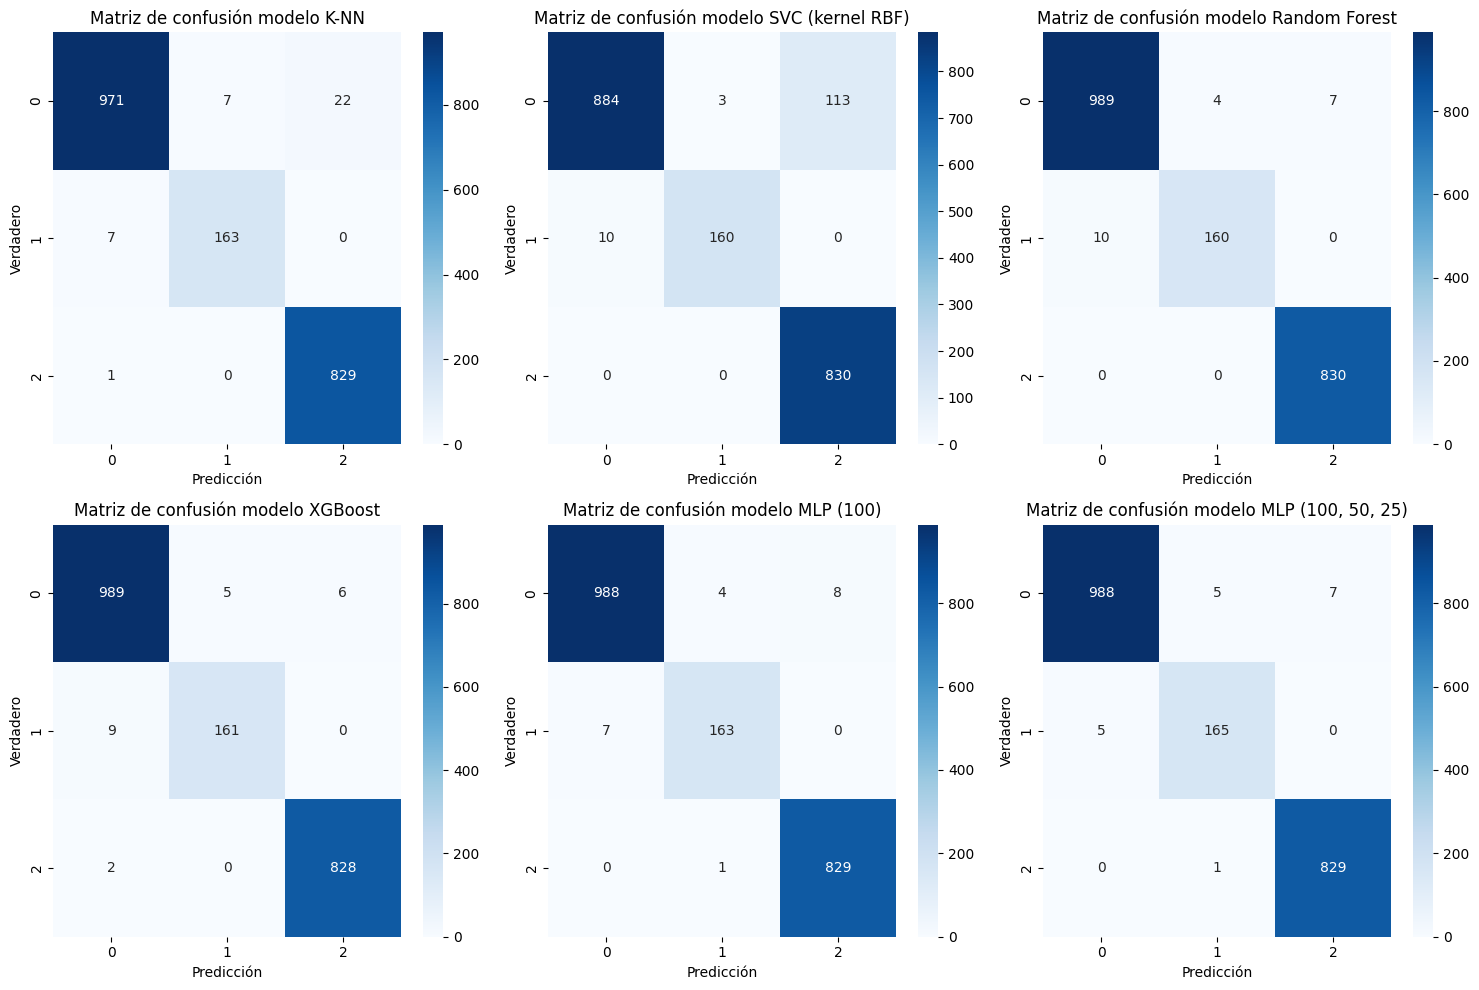

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, model in enumerate(models):
    conf_matrix = confusion_matrix(y_test, y_pred[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title('Matriz de confusión modelo ' + model_names[i])
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Verdadero')
plt.tight_layout()
plt.show()

Como se pudo notar anteriormente, el modelo que tuvo mejores aciertos con la clase menos representada fue MLP (100, 50, 25) y los que tuvieron menores aciertos fueron SVC y RF, pero pueden tomarse como insignificantes.

Por lo tanto, el mejor modelo a utilizar en temas de precisión de predicciones sería MLP (100, 50, 25) y el mejor modelo a utilizar considerando precisión de predicción y rendimiento computacional sería XGBoost.

## **Curva ROC-AUC**

Visualizaremos las curvas ROC-AUC de todos los modelos continuando con la comparación de los modelos a través de las diferentes métricas disponibles.

Notemos que hay que binarizar las etiquetas debido a que roc_curve no es compatible con problemas de clasificación multiple.

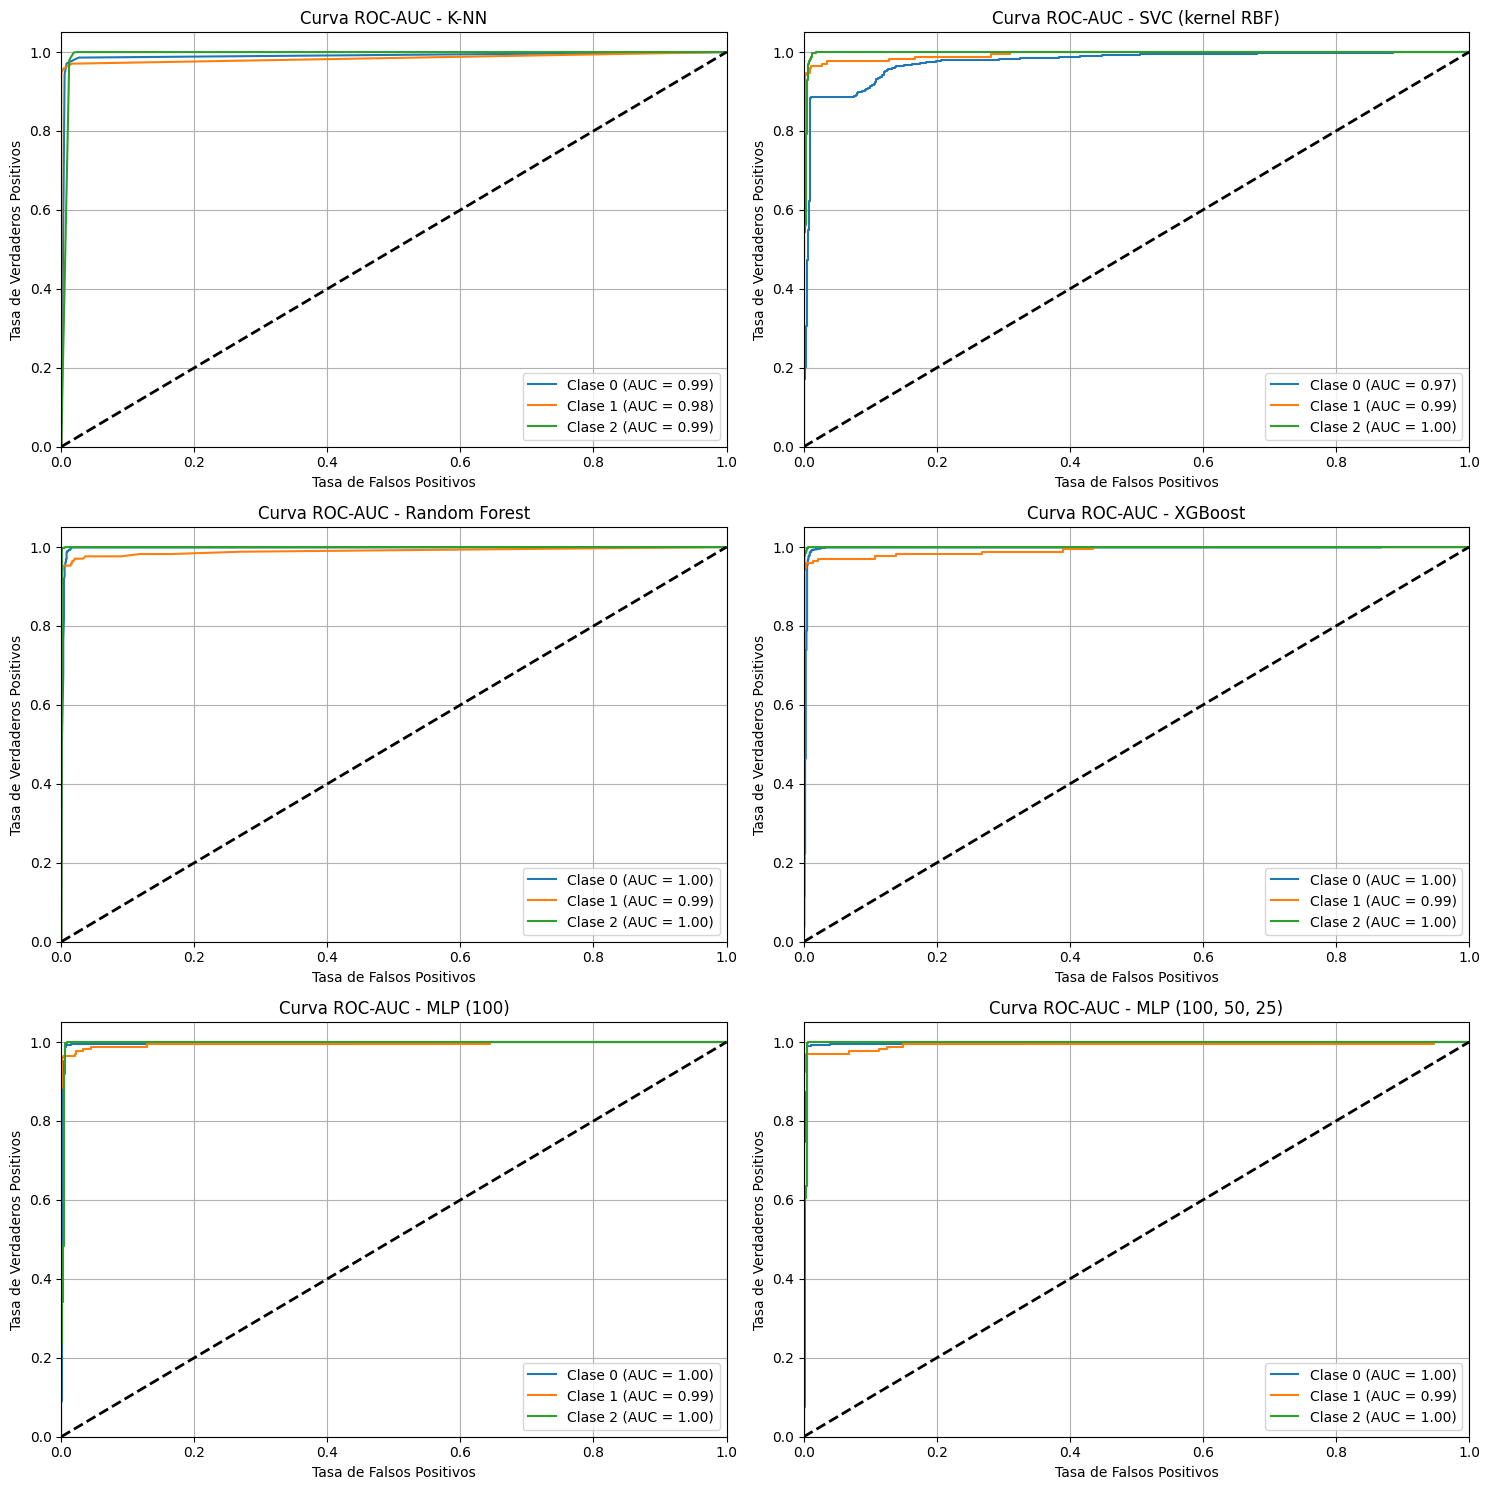

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

model_names = ["K-NN", "SVC (kernel RBF)", "Random Forest", "XGBoost", "MLP (100)", "MLP (100, 50, 25)"]
models = [knn, svc, rf, xgb, mlp_100, mlp_1005025]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, model in enumerate(models):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
         y_score = model.decision_function(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    ax = axes[i]
    for j in range(n_classes):
        ax.plot(fpr[j], tpr[j], label=f'Clase {j} (AUC = {roc_auc[j]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos')
    ax.set_ylabel('Tasa de Verdaderos Positivos')
    ax.set_title('Curva ROC-AUC - ' + model_names[i])
    ax.legend(loc="lower right")
    ax.grid(True)


plt.tight_layout()
plt.show()

Y como ya hemos notado con anterioridad, se sigue cumpliendo que los modelos con mejor rendimiento son los últimos 4.

## **Optimización de Hiperparámetros con GridSearchCV a los mejores modelos**

Como el mejor modelo en términos de rendimiento fue XBGoost, buscaremos sus mejores hiperparámetros para evaluar si posee las mismas o mejores métricas que MLP (100, 50, 25).

Partamos definiendo el modelo sin darle parámetros.

In [ ]:
pipe_xgb = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
])

Definamos la rejilla de parámetros.

In [ ]:
param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 4, 5]
}

Construyamos el GridSearchCV con validación cruzada. Usaremos la métrica f1_macro ya que, a diferencia de acurracy, esta métrica no se ve tan afectada por la clase mayoritaria.

In [ ]:
grid_search_xgb = GridSearchCV(estimator=pipe_xgb,
                             param_grid=param_grid_xgb,
                             scoring='f1_macro',
                             cv=5)

Entrenemos el modelo para encontrar los mejores hiperparámetros.

In [ ]:
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1, 0.2],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__n_estimators': [50, 100, 150]},
             scoring='f1_macro')

Por último mostremos mostremos los mejores hiperparámetros para XGBoost. Luego, procedamos a predecir con este modelo y lo evaluamos con las métricas anteriormente vistas.

In [ ]:
print("Mejores parámetros:", grid_search_xgb.best_params_)

print("\nBest cross-validation F1-macro score:", grid_search_xgb.best_score_)

best_xgb_model = grid_search_xgb.best_estimator_

Mejores parámetros: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}

Best cross-validation F1-macro score: 0.9780574219940806


Procedamos a predecir a través del mejor modelo de XGBoost y evaluemoslo a través de las métricas.

Reporte del modelo XGBoost con los mejores hiperparámetros

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.96      0.95      0.95       170
           2       0.99      1.00      1.00       830

    accuracy                           0.99      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.99      0.99      0.99      2000



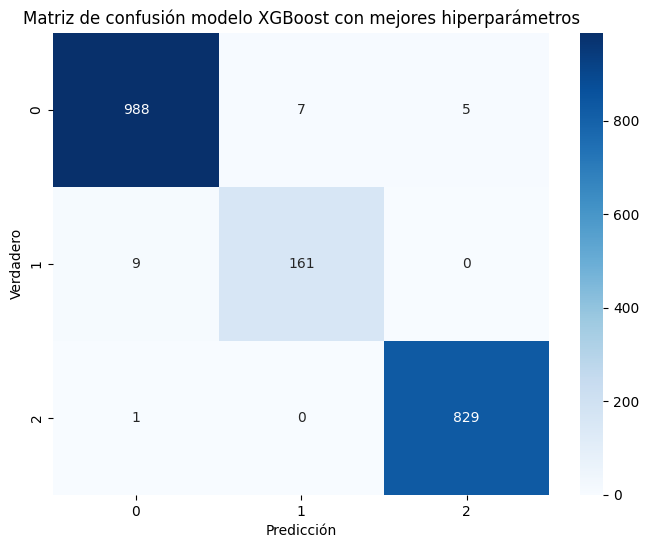

In [ ]:
y_pred_xgb = best_xgb_model.predict(X_test)

print("Reporte del modelo XGBoost con los mejores hiperparámetros")
print('')
print(classification_report(y_test, y_pred_xgb))

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión modelo XGBoost con mejores hiperparámetros')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

Notemos que XGBoost con los mejores hiperparámetros (dentro de una elección razonable) iguala en equivocaciones a  MLP (100, 50, 25) en las clases 0 y 2. Pero en la clase minoritaria 1 el modelo MLP (100, 50, 25) sigue acertando más veces.

Por último, procedamos a realizar un GridSearch pero con MLP para encontrar los mejores hiperpárametros y entregar un modelo que en precisión sea lo más exitoso posible. Así poder entregar un modelo bueno en términos de rendimiento y un modelo bueno en términos de acierto y error.

Partamos definiendo el pipeline sin hiperparámetors para optimizarlos.

In [ ]:
pipe_mlp = imbPipeline([
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42))
])

Definamos la rejilla de hiperparámetros a evaluar.

In [ ]:
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50, 25)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01]
}

Creemos el GridSearchCV.

In [ ]:
grid_search_mlp = GridSearchCV(estimator=pipe_mlp,
                               param_grid=param_grid_mlp,
                               scoring='f1_macro',
                               cv=5)

Entrenemos el modelo para encontrar los mejores hiperparámetros.

In [ ]:
grid_search_mlp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('mlp',
                                        MLPClassifier(random_state=42))]),
             param_grid={'mlp__activation': ['relu', 'tanh'],
                         'mlp__alpha': [0.0001, 0.001, 0.01],
                         'mlp__hidden_layer_sizes': [(50,), (100,), (50, 25),
                                                     (100, 50, 25)],
                         'mlp__solver': ['adam', 'sgd']},
             scoring='f1_macro')

Por último mostremos mostremos los mejores hiperparámetros para MLP. Luego, procedamos a predecir con este modelo y lo evaluamos con las métricas anteriormente vistas.

In [ ]:
print("Mejores parámetros:", grid_search_mlp.best_params_)

print("\nMejor f1-score con validación cruzada:", grid_search_mlp.best_score_)

best_mlp_model = grid_search_mlp.best_estimator_

Mejores parámetros: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'adam'}

Mejor f1-score con validación cruzada: 0.9855412250640662


Procedamos a predecir a través del mejor modelo de MLP y evaluemoslo a través de las métricas.

Reporte del modelo MLP con los mejores hiperparámetros

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.98      0.96      0.97       170
           2       0.99      1.00      0.99       830

    accuracy                           0.99      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       0.99      0.99      0.99      2000



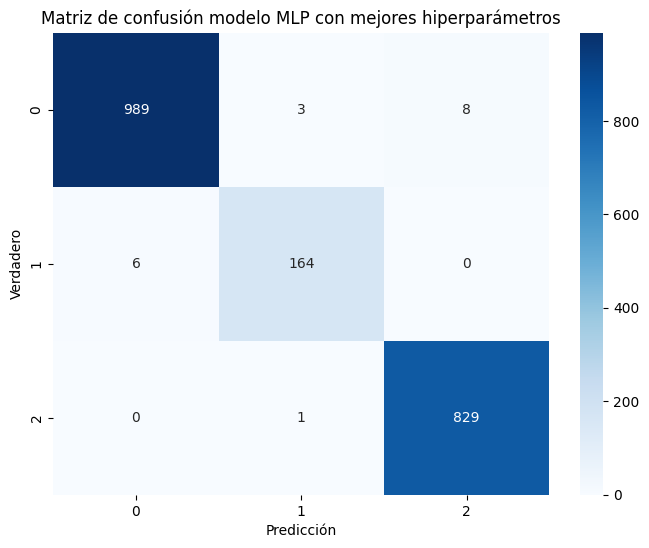

In [ ]:
y_pred_mlp = best_mlp_model.predict(X_test)

print("Reporte del modelo MLP con los mejores hiperparámetros")
print('')
print(classification_report(y_test, y_pred_mlp))

conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión modelo MLP con mejores hiperparámetros')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

Por lo tanto, los dos mejores modelos para la clasificación de objetos estelares son:

* XGBoost:
  * Tasa de aprendizaje = 0.1
  * Máxima profundidad = 3
  * Número de árboles = 150

* MLP:
  * Función de activación = relu
  * Término de regularización L2 = 0.001
  * Capas ocultas = (100,)
  * Optimizador = adam

# **Conclusiones**



**1. Análisis Exploratorio de Datos (EDA):**

Tras un análisis inicial, se determinó que variables como **objid, run, rerun, camcol, field, specobjid, plate, mjd, y fiberid** no aportaban información relevante para la clasificación basada en magnitudes fotométricas, por lo que se decidió eliminarlas.

Las estadísticas descriptivas iniciales y los boxplots mostraron la presencia de outliers en las variables. A través del rango intercuartílico (IQR) y del z-score se confirma esta observación, mostrando un porcentaje significativo de outliers (15.8% según IQR, 5.3% según z-score). Esto justificó el uso posterior de técnicas de escalado robustas (RobustScaler).

El análisis de correlación reveló una alta correlación entre las cinco magnitudes fotométricas (u, g, r, i, z). La variable redshift mostró una correlación moderada con las magnitudes, especialmente influenciada por la clase de cuásar (clase 1).

Los histogramas mostraron que las magnitudes fotométricas se distribuyen como una variable normal en todas las clases.

Se identificó claramente un desbalance de clases, donde las galaxias y las estrellas son mucho más numerosas que los cuásares.

**2. Visualización (t-SNE):**

Para visualizar la estructura de los datos en 2D, se aplicó una reducción de dimensionalidad utilizando t-SNE. La proyección resultante con t-SNE demostró una clara separabilidad entre las tres clases de objetos estelares. Esta observación es crucial, ya que sugiere que los modelos de clasificación tendrán una buena claridad al momento de distinguir entre las clases.

**3. Balanceo de clases (SMOTE):**

El desbalance de clases identificado en el EDA fue corregido en el conjunto de entrenamiento mediante la técnica SMOTE. Este paso fue fundamental para prevenir que los modelos se sesgaran hacia la predicción de la clase mayoritaria y asegurar un mejor rendimiento en la clasificación de las clases minoritarias.

**4. Modelamiento y evaluación inicial:**

Se entrenaron varios modelos de clasificación supervisada, incluyendo K-NN, SVC (con kernel RBF), Random Forest, XGBoost y dos arquitecturas de Redes Neuronales Multicapa (MLP). La elección de estos modelos se basó en su idoneidad para problemas de clasificación, considerando la naturaleza de los datos y la separabilidad observada. Todos los modelos se entrenaron dentro de pipelines que incluían RobustScaler y SMOTE como preprocesamiento.

La evaluación inicial de los modelos en el conjunto de prueba utilizando **classification_report** y matrices de confusión mostró que la mayoría de los modelos obtuvieron un rendimiento muy bueno, con métricas de precisión, recall y f1-score generalmente altas. La tabla comparativa de métricas clave y las matrices de confusión revelaron que todos los modelos, excepto SVC, tuvieron un rendimiento similar y alto, con accuracy y macro avg f1-score cercanos al 0.98-0.99. El modelo MLP (100, 50, 25) mostró una ligera ventaja en la predicción de la clase minoritaria (Clase 1), con un f1-score de 0.97. Las curvas ROC-AUC confirmaron el buen desempeño de los modelos, especialmente Random Forest, XGBoost y los MLP, que mostraron áreas bajo la curva cercanas a 1 para todas las clases.

**5. Optimización de hiperparámetros:**

Considerando el buen rendimiento y la eficiencia computacional de XGBoost, se realizó una optimización de hiperparámetros utilizando **GridSearchCV** con f1_macro como métrica de evaluación. Los mejores hiperparámetros encontrados para XGBoost fueron **learning_rate=0.1**, **max_depth=3** y **n_estimators=150**, obteniendo un f1_macro de validación cruzada de 0.978. La evaluación del modelo XGBoost optimizado en el conjunto de prueba mostró un rendimiento excelente, con un F1-score de 0.95 para la clase 1, Accuracy de 0.99 y Macro Avg F1-score de 0.98.

Para buscar el modelo con la máxima precisión posible, se realizó una optimización similar para MLP. Los mejores hiperparámetros para MLP fueron **activation='relu'**, **alpha=0.001**, **hidden_layer_sizes=(100,)** y **solver='adam'**, con un f1_macro de validación cruzada de 0.9855. El MLP optimizado en el conjunto de prueba alcanzó un F1-score de 0.97 para la clase 1, Accuracy de 0.99 y Macro Avg F1-score de 0.99.

**6. Conclusión final y recomendaciones:**

Basado en la evaluación de los modelos, se identifican dos modelos principales como los más adecuados para la clasificación de objetos estelares a partir de sus magnitudes fotométricas:

*   **XGBoost Optimizado:** Con **learning_rate=0.1**, **max_depth=3** y **n_estimators=150**. Este modelo ofrece un rendimiento eficiente con métricas muy altas en todas las clases, incluyendo un buen manejo en la predicción de la clase minoritaria. Destaca por su eficiencia computacional, lo que lo hace ideal para aplicaciones donde la velocidad de predicción es importante.
*   **MLP Optimizado:** Con **activation='relu'**, **alpha=0.001**, **hidden_layer_sizes=(100,)** y **solver='adam'**. Este modelo ligeramente superó a XGBoost en la predicción de la clase minoritaria (F1-score de 0.97 vs 0.95), ofreciendo la máxima precisión de predicción entre los modelos evaluados. Sería la opción preferida cuando la precisión es el factor más crítico, incluso si implica un tiempo de entrenamiento mayor.

Ambos modelos demostraron ser altamente efectivos en la clasificación de objetos estelares y pueden ser herramientas valiosas para que los aficionados a la astronomía identifiquen estrellas, galaxias y cuásares basándose en sus propiedades fotométricas.

# **Parte 2**

El segundo objetivo es construir una red neuronal convolucional (CNN) que clasifique objetos estelares (estrellas y galaxias) a través de imágenes del cielo. La idea es hacer un modelo más didáctico que no implique conocimiento profundo de las características de un objeto estelar, sino que a través de imágenes todas puedan reconocer en el cielo que se está observando. Se detallará el proceso completo hasta la obtención de una CNN adecuada que responda a esta problemática.

# **Librerías**

Procedamos a instalar e importar las librerías necesarias para la construcción de las redes neuronales convolucionales.

In [ ]:
!pip install -q torch torchvision matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import requests
import io
from torch.utils.data import DataLoader
from tqdm import tqdm

# **Dataset**

El dataset a utilizar en la segunda parte de este proyecto es un conjunto de datos creado como parte de un proyecto en el Instituto Aryabhatta de Ciencias de Observación (ARIES), en Nainnital, India. Las imágenes fueron capturadas con un telescopio de 1.3 metros del observatorio ubicado en Devasthal. Las imágenes originales tenían una resolución de 2000x2000 píxeles, pero se recortaron a fragmentos de 64x64 píxeles para aislar las fuentes individuales.

Para etiquetar las imágenes con las clases "star" y "galaxy", se utilizó segmentación para identificar las fuentes y luego consultar las coordenadas centrales de estas con la base de datos SDSS, asignando así una etiqueta a cada recorte.

Los recortes se almacenaron en directorios separados según la clase donde perteneciera cada imagen.

Este dataset fue generado desde cero utilizando datos reales, y está diseñado para entrenar modelos de visión por computadora que clasifiquen fuentes estelares como estrellas y galaxias en imágenes astronómicas.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dummy-astronomy-data


Procedamos a mostrar una imagen de cada una de las clases, es decir una estrella y una galaxia.

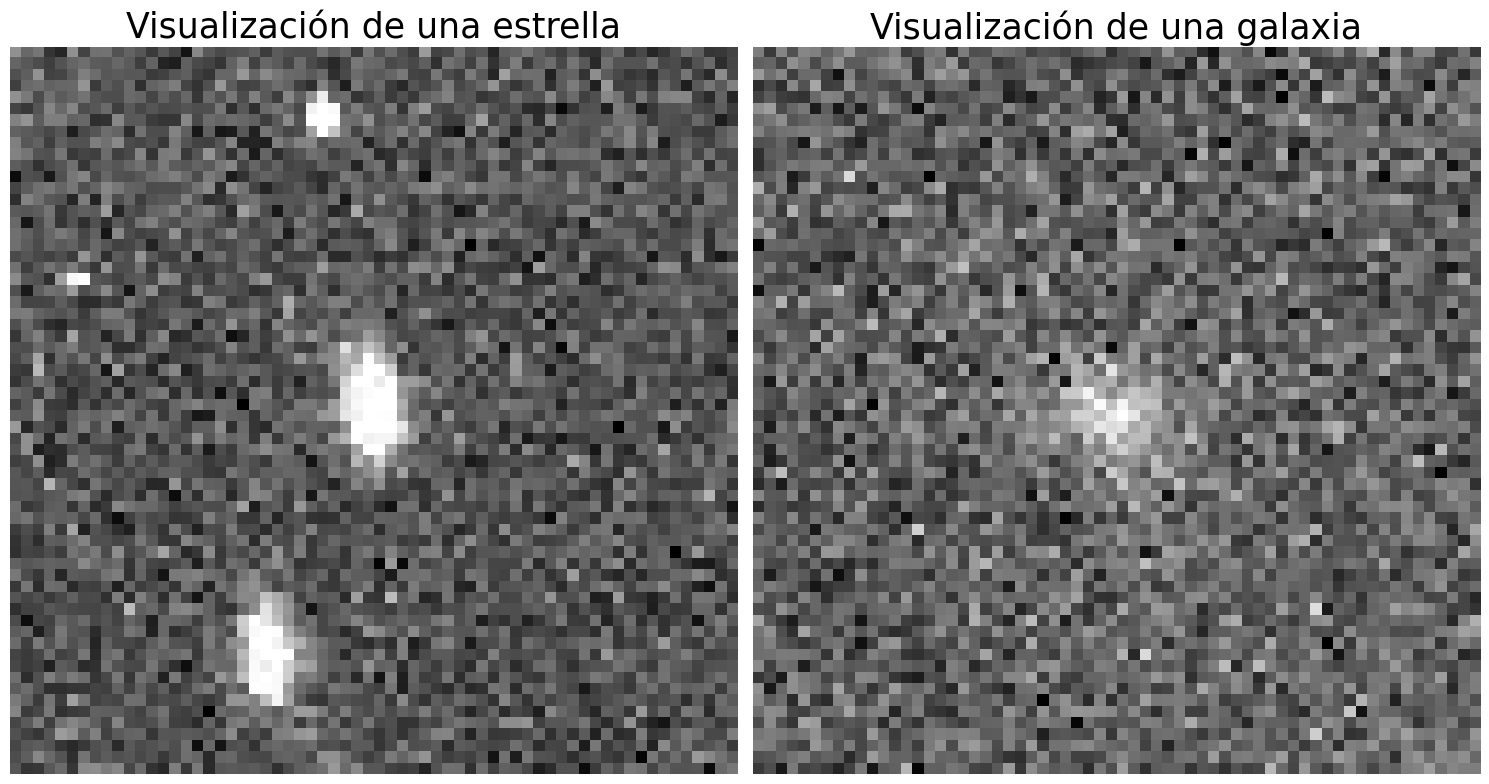

In [ ]:
import os

dataset_path = path + "/Cutout Files"

star_path = os.path.join(dataset_path, 'star')
galaxy_path = os.path.join(dataset_path, 'galaxy')

star_images = [os.path.join(star_path, img) for img in os.listdir(star_path) if img.endswith('.jpg')]
galaxy_images = [os.path.join(galaxy_path, img) for img in os.listdir(galaxy_path) if img.endswith('.jpg')]

img_star = Image.open(star_images[0])
img_galaxy = Image.open(galaxy_images[0])

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()
name = ["estrella", "galaxia"]

for i, img in enumerate([img_star, img_galaxy]):
    axes[i].imshow(img)
    axes[i].set_title(f"Visualización de una {name[i]}", fontsize=25)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# **Preprocesamiento**

Procedamos a construir el preprocesamiento de las imagenes y la separación entre imágenes de entrenamiento y testeo.

In [ ]:
import torchvision.datasets as datasets

tfms = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ]
)

# Apliquemos las transformaciones para el preprocesamiento a las imágenes. Al
# cargar las imágenes con torchvision.datasets.ImageFolder() las clases se
# asignan automáticamente basándose en el nombre de los directorios.

ds = datasets.ImageFolder(root=dataset_path, transform=tfms)

# Ahora separemos el dataset en entrenamiento y testeo

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(ds, [train_size, test_size])

Por último, construyamos los mini-batches para poder realizar el entrenamiento. Esto se realiza para que el modelo se efectue de manera más óptima y no reciba todas las imágenes de una vez. Además, los batches de entrenamiento irán mezclados para evitar el overfitting.

In [ ]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

# **Modelamiento**

Ahora, lo que haremos será construir dos CNN, con un enfoque distinto cada una.

Lo primero que haremos será construir un CNN de cero pero simple y luego lo que haremos será modificar una CNN pre-entrenada para, más tarde, comparar la precisión de predicción de cada red.

## **CNN Simple**

Definimos una red neuronal convolucional (CNN) para clasificar las imágenes.
 Notemos que en la primera capa convolucional ingresan 3 canales, los cuales corresponden a los colores rojo, verde y azul, que van de acorde a las imágenes RGB.

Por otro lado, la función ReLU que corresponde a $max(0,x)$ , induce no lienalidad permitiendo que se aprendan relaciones complejas.

Siguiendo en la red, como nn.MaxPool2d(2,2) reduce las dimensiones espaciales (alto y ancho) a la mitad, hay perdida de información, entonces para compensar se duplica el número de filtros en cada capa.

Observemos que no utilizamos más capas convolucionales puesto que tenemos una cantidad de datos reducida y añadir más capas solo aumentaría el overfitting.

En la capa densa, nn.Dropout(0.3) durante el entrenamiento apaga aleatoriamente el 30% de las neuronas de esta capa, esto se hace para evitar el overfitting.

 Además ocupamos kernels de tamaño 3x3 y no más grandes, ya que estos últimos requieren de mayor costo computacional, en cambio, usando filtros pequeños encadenados pueden lograr capturar la misma información, pero con mayor eficiencia.



In [ ]:
class DemoCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(), nn.MaxPool2d(2,2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    def forward(self,x): return self.classifier(self.features(x))

Procedamos a detectar si hay GPU disponible y si hay se pasa el modelo a ese dispositivo.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DemoCNN().to(device)

Definamos la función de pérdida, el optimizador de los parámetros y el programador de tasa de aprendizaje (después de 7 épocas).

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Definamos la función de evaluación del modelo, en este caso usaremos la precisión.

In [ ]:
@torch.no_grad()
def evaluate(net, loader):
    net.eval(); correct = total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = net(xb).argmax(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)
    return correct / total

## **Entrenamiento**

Procedamos a realizar un entrenamiento del modelo en 10 épocas. Visualizaremos la pérdida y la precisión de cada modelo al final de cada época.

In [ ]:
# Listas para guardar la pérdida y la precisión de cada época
train_loss_list = []
val_acc_list = []

# Parámetros para el entrenamiento
device   = "cuda" if torch.cuda.is_available() else "cpu"
epochs   = 10
b_train  = 128
b_test   = 256
lr       = 1e-3
wd       = 1e-4

# Bucle de 10 épocas para el entrenamiento de la CNN
for ep in range(1, epochs + 1):
    model.train()
    running = 0

    loop = tqdm(train_dl,
                desc=f"Epoch {ep}/{epochs}",
                leave=False)

    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        loss = criterion(model(xb), yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * xb.size(0)
        loop.set_postfix(loss=loss.item())

    scheduler.step()

    train_loss = running / len(train_ds)
    val_acc = evaluate(model, test_dl)

    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {ep:02d}: train loss {train_loss:.3f} | "
          f"val acc {val_acc*100:.2f}%")

Epoch 01: train loss 0.781 | val acc 76.32%


Epoch 02: train loss 0.489 | val acc 77.82%


Epoch 03: train loss 0.400 | val acc 86.84%


Epoch 04: train loss 0.337 | val acc 77.69%


Epoch 05: train loss 0.276 | val acc 88.35%


Epoch 06: train loss 0.262 | val acc 89.47%


Epoch 07: train loss 0.248 | val acc 87.09%


Epoch 08: train loss 0.186 | val acc 89.60%


Epoch 09: train loss 0.171 | val acc 90.10%


Epoch 10: train loss 0.153 | val acc 89.72%


In [ ]:
torch.save(model.state_dict(), 'demo_cnn_trained.pth')

Grafiquemos la pérdida y la precisión de modelo en el entrenamiento después de cada época.

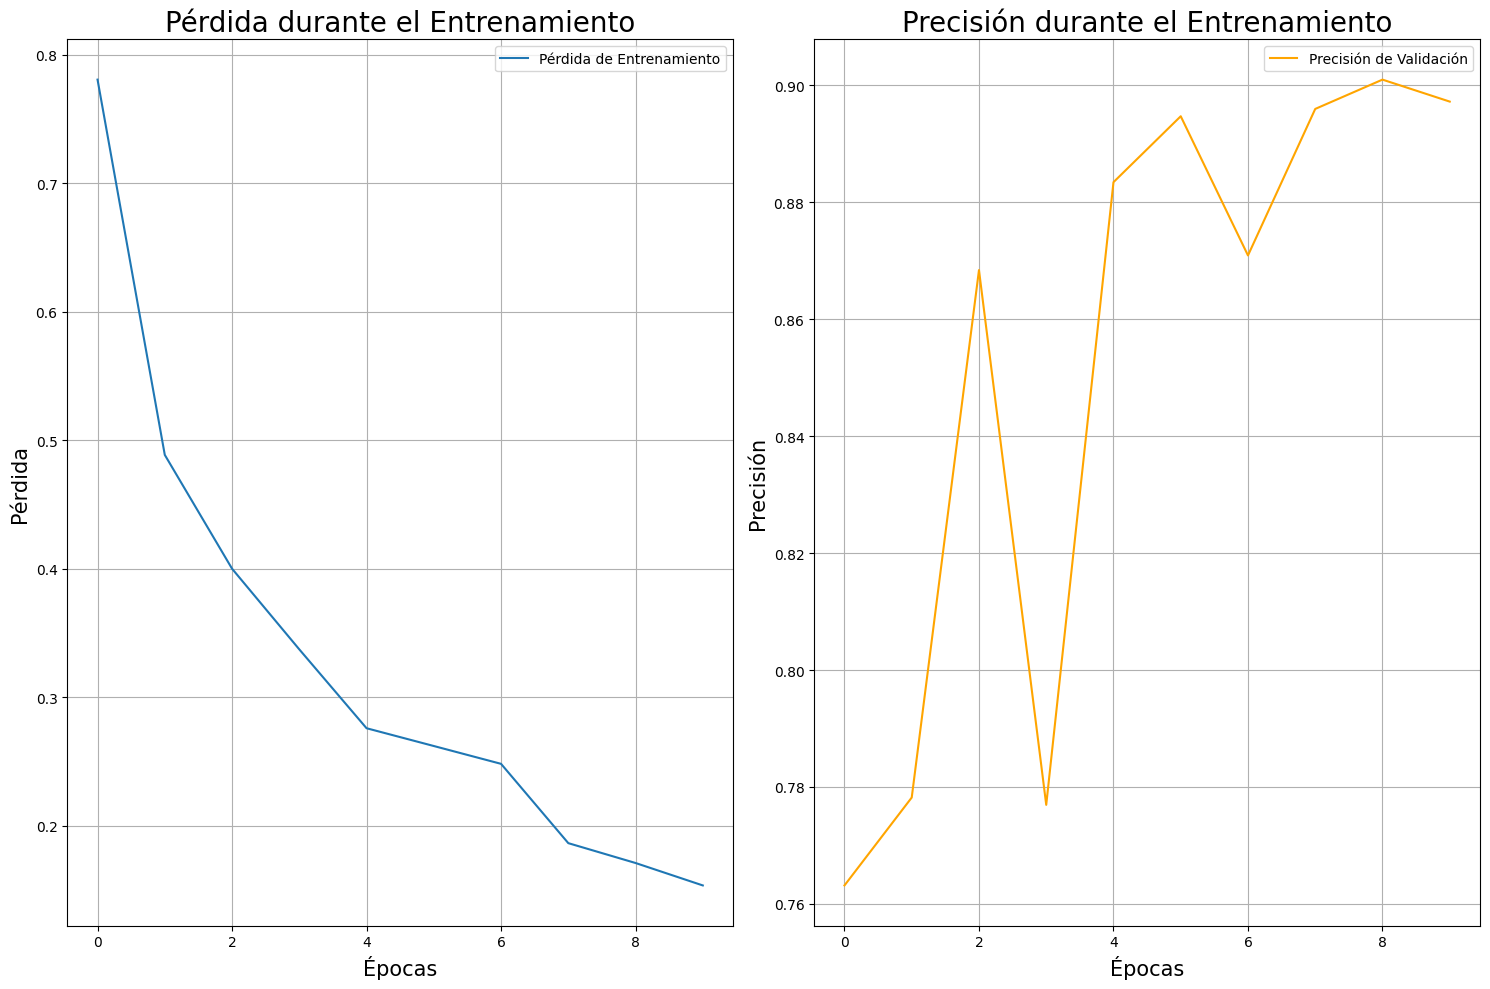

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

# Gráfica para la pérdida en el entrenamiento
axes[0].plot(train_loss_list, label="Pérdida de Entrenamiento")
axes[0].set_title("Pérdida durante el Entrenamiento", fontsize=20)
axes[0].set_xlabel("Épocas", fontsize=15)
axes[0].set_ylabel("Pérdida", fontsize=15)
axes[0].legend()
axes[0].grid(True)

# Gráfica para la precisión en el entrenamiento
axes[1].plot(val_acc_list, label="Precisión de Validación", color='orange')
axes[1].set_title("Precisión durante el Entrenamiento", fontsize=20)
axes[1].set_xlabel("Épocas", fontsize=15)
axes[1].set_ylabel("Precisión", fontsize=15)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Notemos que para el gráfico de pérdida se tiene una disminución constante a lo largo de las épocas, lo que indica que el modelo está aprendiendo y ajustando los parámetros de manera correcta. Además, como no hay perdida que suba de manera repentina, entonces se tiene un buen ajuste de los hiperparámetros.

Para el gráfico de precisión, pese a que fluctúa en algunas partes, tiende a aumentar a lo largo de las épocas, alcanzando valores superiores al 90%. Las fluctuaciones
se pueden deber a que el conjunto de validación es pequeño o bien, no del todo representativo.

Por otro lado, notemos que no hay sobreajuste evidente, ya que la curva de precisión no se estanca.



# **Predicción y Evaluación**

Partamos importando las librerías necesarias para visualizar las imágenes predichas.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms.functional as F

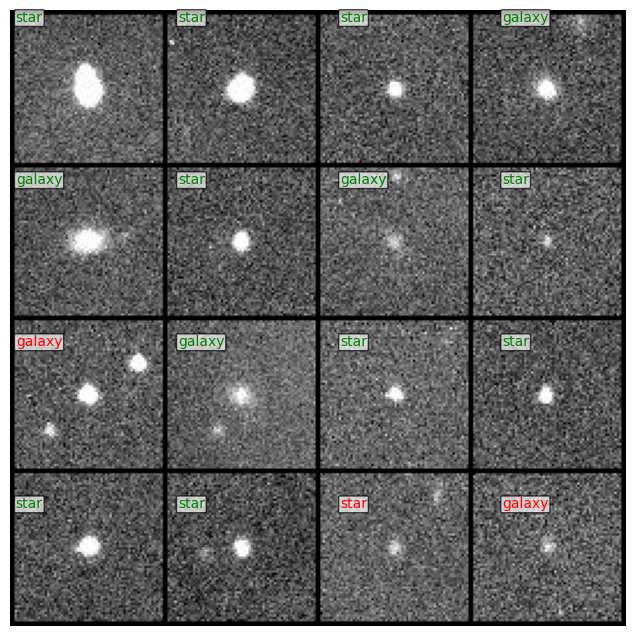

In [ ]:
# Tomamos un batch de 16 imágenes del conjunto de prueba
data_iter = iter(test_dl)
imgs, labels = next(data_iter)

# Pasamos por la red para obtener predicciones del modelo (modo evaluación)
model.eval()
with torch.no_grad():
    logits = model(imgs.to(device))
    preds  = logits.argmax(1).cpu()

# Des-normaliza las imágenes para mostrarlas en RGB
def denorm(t):
    mean = torch.tensor((0.4914,0.4822,0.4465)).view(3,1,1)
    std  = torch.tensor((0.2023,0.1994,0.2010)).view(3,1,1)
    return torch.clamp(t * std + mean, 0, 1)

grid = vutils.make_grid(denorm(imgs)[:16], nrow=4, padding=2)

# Plot con títulos
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")

# Añadimos textos de etiqueta-real / pred-modelo
classes = ds.classes
for idx in range(16):
    y = idx // 4; x = idx % 4
    true = classes[labels[idx]]
    pred = classes[preds[idx]]
    color = "green" if true==pred else "red"
    plt.text(x*70+2, y*70+6, f"{pred}",
             color=color, fontsize=10, ha="left", va="bottom",
             bbox=dict(boxstyle="round,pad=0.1", fc="white", alpha=0.7))
plt.show()

Se consideran las etiquetas rojas como mal clasificados y las verdes como bien clasificados. Se observa que las imágenes bien clasificadas superan a las que no.

Ahora, realicemos una visualización con Grad-CAM para poder entender que partes de las imágenes influyen más en la toma de decisiones de la red neuronal convolucional.

In [ ]:
!pip -q install grad-cam requests

In [ ]:
!pip install -q --upgrade grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import utils

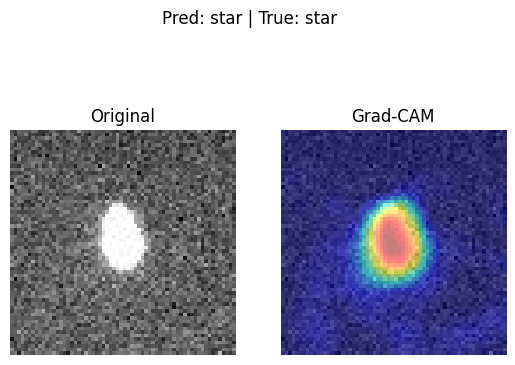

In [ ]:
# Tomar un lote de prueba (del DataLoader que ya tenemos)
imgs, labels = next(iter(test_dl))

# Pasamos por la red para obtener predicciones del modelo (modo evaluación)
model.eval()
with torch.no_grad():
    logits = model(imgs.to(device))
    preds  = logits.argmax(1).cpu()

# Encontrar un ejemplo clasificado correctamente
correct_indices = [i for i, (true, pred) in enumerate(zip(labels, preds)) if true == pred]

if len(correct_indices) > 0:
    # Seleccionar el primer ejemplo clasificado correctamente
    idx_to_show = correct_indices[0]
    img, label = imgs[idx_to_show:idx_to_show+1], labels[idx_to_show]

    # Preparar Grad-CAM sobre la última conv de nuestra red
    target_layer = model.features[-3]
    img = img.to(device)

    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=img)[0]

    # Des-normalizar para visualizar
    def denorm(t):
      mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
      std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
      return torch.clamp(t*std+mean, 0, 1)

    rgb = denorm(img.cpu()[0]).permute(1,2,0).numpy()
    cam_img = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

    classes = ds.classes
    pred = model(img).argmax(1).item()

    true = label.item()
    title = f'Pred: {classes[pred]} | True: {classes[true]}'
    plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off') ;plt.title('Original')
    plt.subplot(1,2,2); plt.imshow(cam_img); plt.axis('off') ;plt.title('Grad-CAM')
    plt.suptitle(title, fontsize=12)
    plt.show()
else:
    print("No se encontró ningún ejemplo clasificado correctamente en este lote.")

En el mapa de calor observamos que la red se enfoca en la región central, donde reconoce bien el contorno, además de darle relevancia a la luminosidad, lo cual hace sentido, puesto que la diferencia entre estrellas y galaxias se basa en el centro de emisión de la luz y estructura.

Ahora, procesaremos una imagen de internet y la pasaremos por el modelo para predecirla y ver si el modelo predice de buena forma con la clase minoritaria (galaxia).

In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ44_CQps08AJLJSkRCRR2R7fDRQNIIxOZtUw&s"
response = requests.get(url)
img_pil = Image.open(io.BytesIO(response.content)).convert("RGB")

Visualicemos la imagen

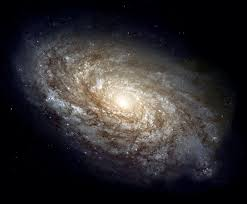

In [ ]:
img_pil

Realicemosle el preprocesamiento.

In [ ]:
to_tensor = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Le damos una dimension más para convertirlo en mini-batch de una imagen
img = to_tensor(img_pil).unsqueeze(0)

Por último, usemos el modelo para predecir que tipo de objeto estelar estamos observando.

In [ ]:
img = img.to(device)
prediction_tensor = model(img).argmax(1)
predicted_class_index = prediction_tensor.item()
classes = ds.classes
predicted_class_name = classes[predicted_class_index]

print(f"La clase predicha para la foto extraída de internet es {predicted_class_name}")

La clase predicha para la foto extraída de internet es galaxy


# **Transfer Learning**

Por último, en busca de mejorar la precisión del modelo, reutilizaremos una red neuronal pre-entrenada para usar sus capas básicas y entrenar sus capas más complejas con nuestros datos.

Esto nos ayudará en la búsqueda de un modelo más robusto sin necesitar muchos datos y con un tiempo de cómputo mucho menor para obtener un mejor rendimiento del modelo.

Para esto, se utilizará una arquitectura de CNN profunda introducida por Microsoft Research llamada ResNet. ResNet soluciona soluciona el problema de que al aumentar la profundidad de la red se comenzaba a ver que el modelo empeoraba. La idea detrás de esta red es introducir bloques residuales, que permiten que la red salte capas cuando sea necesario y así sea más fácil entrenar redes muy profundas y se mantenga el flujo del gradiente durante el backpropagation.

La estrategia que utilizaremos lleva el nombre de Fine-Tuning Parcial el cuál se caracteriza por 3 épocas extractor más 3 épocas fine-tuning parcial.

Procedamos a realizar el modelo:

In [ ]:
from torchvision import models

In [ ]:
res_model = models.resnet18(weights='IMAGENET1K_V1')
res_model.fc = nn.Linear(res_model.fc.in_features, 2)

for name, p in res_model.named_parameters():
  if name.startswith('layer4') or name.startswith('fc'):
    p.requires_grad = True
  else:
    p.requires_grad = False

optimizer = torch.optim.Adam([
    {'params': res_model.layer4.parameters(), 'lr': 1e-4},
    {'params': res_model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
res_model = res_model.to(device)
res_model.fc.to(device)

Linear(in_features=512, out_features=2, bias=True)

In [ ]:
def accuracy(net, loader):
  net.eval(); correct = total = 0
  with torch.no_grad():
    for xb, yb in loader:
      pred = net(xb.to(device)).argmax(1).cpu()
      correct += (pred==yb).sum().item()
      total += yb.size(0)
  return correct/total

In [ ]:
# Entrenamiento
epochs = 10
for ep in range(1,epochs+1):
  res_model.train()
  pbar = tqdm(train_dl, desc=f'Epoch {ep}/{epochs}')
  for xb, yb in pbar:
    xb, yb = xb.to(device), yb.to(device)
    loss = criterion(res_model(xb), yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    pbar.set_postfix(loss=f'{loss.item():.3f}')
  val_acc = accuracy(res_model, test_dl)
  print(f'Época {ep:02d} | val acc: {val_acc*100:.2f}%')

Epoch 1/10: 100%|██████████| 100/100 [00:06<00:00, 16.24it/s, loss=0.734]


Época 01 | val acc: 72.43%


Epoch 2/10: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s, loss=0.264]


Época 02 | val acc: 75.56%


Epoch 3/10: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s, loss=0.051]


Época 03 | val acc: 77.69%


Epoch 4/10: 100%|██████████| 100/100 [00:06<00:00, 15.76it/s, loss=0.190]


Época 04 | val acc: 78.32%


Epoch 5/10: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s, loss=0.058]


Época 05 | val acc: 77.57%


Epoch 6/10: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s, loss=0.006]


Época 06 | val acc: 77.07%


Epoch 7/10: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s, loss=0.007]


Época 07 | val acc: 79.70%


Epoch 8/10: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s, loss=0.041]


Época 08 | val acc: 76.57%


Epoch 9/10: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s, loss=0.013]


Época 09 | val acc: 78.07%


Epoch 10/10: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s, loss=0.003]


Época 10 | val acc: 79.45%


In [ ]:
torch.save(res_model.state_dict(), 'res_train.pth')

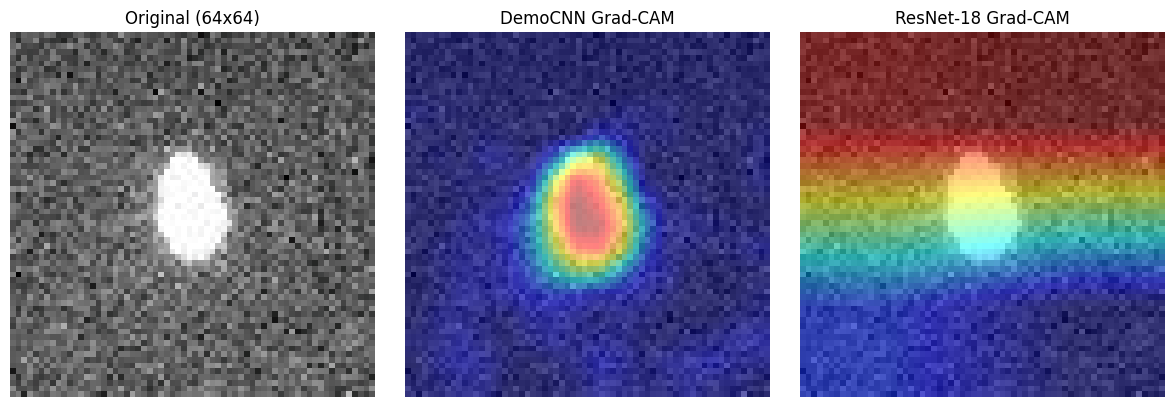

In [ ]:
from torchvision import models

def denorm(t):
  mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
  std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
  return torch.clamp(t*std+mean, 0, 1)

img, label = test_ds[0]
img = img.unsqueeze(0).to(device)

# CNN Básica (DemoCNN)

cnn = DemoCNN().to(device)
cnn.load_state_dict(torch.load('demo_cnn_trained.pth'))
cnn.eval()
layer_cnn = cnn.features[-3]

with GradCAM(model=cnn, target_layers=[layer_cnn]) as cam:
    cam_cnn = cam(input_tensor=img)[0]

# CNN con ResNet-18

resnet_model_vis = models.resnet18()
resnet_model_vis.fc = nn.Linear(resnet_model_vis.fc.in_features, 2)
resnet_model_vis = resnet_model_vis.to(device)
resnet_model_vis.load_state_dict(torch.load('res_train.pth'))
resnet_model_vis.eval()
layer_resnet = resnet_model_vis.layer4[-1]

with GradCAM(model=resnet_model_vis, target_layers=[layer_resnet]) as cam:
    cam_res = cam(input_tensor=img)[0]

# Visualizar
rgb = denorm(img.cpu()[0]).permute(1,2,0).numpy()
overlay_cnn = show_cam_on_image(rgb, cam_cnn, use_rgb=True)
overlay_res = show_cam_on_image(rgb, cam_res, use_rgb=True)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(rgb)
ax[0].set_title('Original (64x64)')
ax[0].axis('off')
ax[1].imshow(overlay_cnn)
ax[1].set_title('DemoCNN Grad-CAM')
ax[1].axis('off')
ax[2].imshow(overlay_res)
ax[2].set_title('ResNet-18 Grad-CAM')
ax[2].axis('off')
plt.tight_layout()
plt.show()

Como se puede apreciar, el modelo CNN simple tiende a enfocarse en los cambios de luminosidad localizados directamente sobre la fuente. En cambio, el modelo basado en Fine Tuning con ResNet muestra una mayor sensibilidad a las variaciones de luminosidad a lo largo del eje vertical.

# **Predicción y Evaluación**

Procedamos a realizar las predicciones de los dos modelos y a evaluarlos con las distintas métricas para clasificación y así ver sus rendimientos.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

model_names = ["DemoCNN", "ResNet-18"]
models = [model, res_model]

y_true = []
y_pred = []

for _, labels in test_dl:
    y_true.extend(labels.tolist())

for current_model in models:
    current_model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in test_dl:
            inputs = inputs.to(device)
            outputs = current_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
    y_pred.append(predictions)

In [ ]:
for i, model_name in enumerate(model_names):
    print(f"Reporte de Clasificación para el modelo: {model_name}")
    print(classification_report(y_true, y_pred[i], target_names=ds.classes))
    print("-" * 50)

Reporte de Clasificación para el modelo: DemoCNN
              precision    recall  f1-score   support

      galaxy       0.82      0.72      0.77       189
        star       0.92      0.95      0.93       609

    accuracy                           0.90       798
   macro avg       0.87      0.84      0.85       798
weighted avg       0.89      0.90      0.89       798

--------------------------------------------------
Reporte de Clasificación para el modelo: ResNet-18
              precision    recall  f1-score   support

      galaxy       0.61      0.36      0.45       189
        star       0.82      0.93      0.87       609

    accuracy                           0.79       798
   macro avg       0.72      0.64      0.66       798
weighted avg       0.77      0.79      0.77       798

--------------------------------------------------


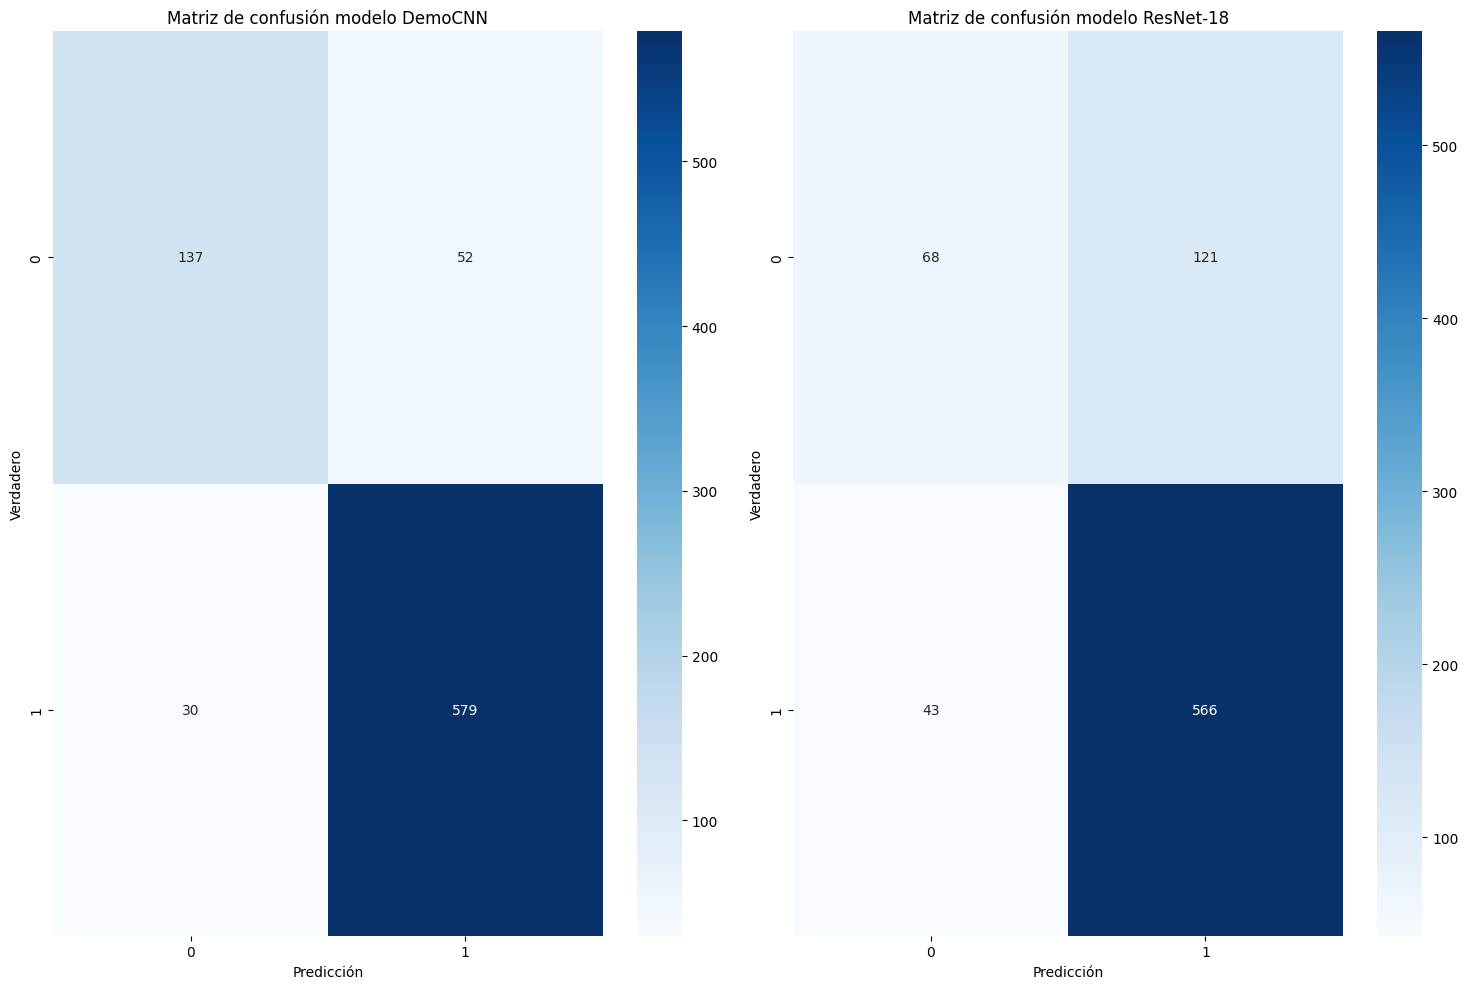

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()

for i, model_name in enumerate(models):
    conf_matrix = confusion_matrix(y_true, y_pred[i])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title('Matriz de confusión modelo ' + model_names[i])
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Verdadero')
plt.tight_layout()
plt.show()

# **Conclusiones**

**1. Modelamiento y evaluación inicial:**

En esta parte del proyecto se entrenaron dos modelos distintos para clasificación de imágenes, uno basado en redes neuronales convolucionales simples (diseñada desde cero) y un modelo ya preentrenado (ResNet-18) ajustado mediante fine-tuning. Estos modelos se entrenaron usando librerias como pytorch, que permite optimizar ciertas operaciones al momento de ajustar un modelo de CNN como la multiplicación de matrices y la convolución (mediante el algoritmo de FFT).

La evaluación inicial de los modelos al momento del entrenamiento de las redes neuronales muestra que el enfoque basado en CNN simples converge de manera mas rapida, alcanzando una precisión de validación igual a 89.72%, mientras que el modelo ya preentrenado (ResNet-18) alcanza una precisión del 79.45% luego de 10 epocas. Además, a partir de la visualización con Grad-CAM se observa que el modelo de CNN simples logra captar de mejor manera las caracteristicas escensiales de los objetos estelares.

A partir de las matrices de confusión, se observa que la CNN simples alcanzó una mayor precisión global (91.2%) en comparación con ResNet-18 (81.5%). Además, el modelo de CNN simples cometió menos errores en ambas clases, en particular mostrando un menor número de falsos positivos. Estos resultados sugieren que, en este caso particular, el modelo diseñado desde cero se adaptó mejor al conjunto de datos, posiblemente debido a que su estructura más simple evitó el sobreajuste o fue más adecuada para la distribución específica del problema.

**2. Conclusión final y recomendaciones**

Basandonos en la evaluación de los modelos podemos concluir que el enfoque que mejor desempeño tubo fue el de redes convolucionales simples, el cual mostro una muy buena convergencia y ajuste a los datos de entrenamiento, al igual que su desempeño global. No obstante, es importante considerar que estos resultados pueden depender de la calidad y tamaño del dataset, por lo que en otras condiciones el fine-tuning de modelos preentrenados podría ofrecer ventajas relevantes.

# **Conclusiones generales del proyecto**

**1. Comparación y limitación de cada enfoque**

A lo largo del proyecto comparamos distintos enfoques para resolver dos problemas de clasificación, cada uno con datasets que presentaban diferentes estructuras y tipos de variables, lo que nos permitió abordar estos problemas usando distintas estrategias. Esta comparación nos permitió entender mejor las ventajas y limitaciones de cada enfoque en función del contexto del problema a resolver.

En la primera parte del proyecto aprendimos que distintos algoritmos pueden ofrecer soluciones igualmente efectivas, pero con ventajas particulares según el objetivo específico. Por un lado, modelos como XGBoost demostraron ser altamente eficientes computacionalmente, manteniendo un rendimiento muy bueno incluso en la predicción de clases minoritarias. Por otro lado, los MLP optimizados alcanzaron la máxima precisión, especialmente al clasificar la clase minoritaria.

En la segunda parte del proyecto aprendimos que, si bien los modelos preentrenados como ResNet-18 son herramientas poderosas que aprovechan conocimiento previo y suelen mostrar buenos resultados en muchos contextos, no garantizan un mejor desempeño en todos los casos. En este sentido el modelo de CNN diseñada desde 0 parece haberse adaptado bien a este tipo de imagenes donde el nivel de concentración de luz es clave para distinguir una estrella de una galaxia.

**2. Posibles trabajos futuros**

A continuación se proponen algunos trabajos futuros que nos permitan mejorar el rendimiento o explorar nuevas formas de abordar los problemas:

Para la primera parte del proyecto sería valioso incorporar tecnicas más sofisticadas para detectar outliers, como por ejemplo al incorporar incertidumbre a los datos a traves de modelos Bayesianos o usar las variables de holgura del modelo SVC para detectar las anomalias. También se propone explorar nuevas arquitecturas de modelos, como redes neuronales más profundas, que podrían mejorar el rendimiento en tareas más complejas. Aplicar técnicas de interpretabilidad para entender el impacto de cada variable en las decisiones del modelo.

Para la segunda parte del proyecto se propone se propone ampliar el conjunto de datos y aplicar técnicas de aumentación más robustas para mejorar la capacidad generalizadora de los modelos. También sería interesante experimentar con arquitecturas más recientes como EfficientNet o Vision Transformers.